In [48]:
# !pip install pyod -q 

In [49]:
import numpy as np
import pandas as pd
import sklearn
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from pyod.models.pca import PCA as pyod_PCA
import string
import datetime
from dateutil.relativedelta import relativedelta

import warnings
warnings.filterwarnings("ignore")

In [50]:
# Авторизация гугл диска
# from google.colab import drive
# drive.mount('/content/drive')

In [51]:
# Здесь укажите путь к папке с ноутбуком и датасетом на гугл диске
# %cd  /content/drive/

In [52]:
# создаем датасет для проверки функций
np.random.seed(42)
n = 600
assert_data = pd.DataFrame(columns=['id', 'member_id', 'issue_d', 'target', 'test_flg', 'atr_int_1', 'atr_int_2', 'atr_int_3', 'atr_cat_1', 'atr_cat_2', 'atr_cat_3'])
assert_data['id'] = range(n)
assert_data['member_id'] = range(n)
assert_data['issue_d'] = [datetime.datetime.strftime(datetime.date(2000,1,1) + relativedelta(months=d),'%Y-%m-%d') for d in range(60)] * int(n/60)
assert_data['target'] = [np.random.randint(2) for i in range(n)]
assert_data['test_flg'] = [np.random.randint(2) for i in range(n)]
for i in range(1, 4):
    assert_data[f'atr_int_{i}'] = np.random.random(n)
    assert_data[f'atr_cat_{i}'] = np.random.choice(' '.join(c for c in string.ascii_uppercase).split(), n)

assert_tech_columns = ['id', 'member_id', 'issue_d', 'target']
assert_interrval_features = [f'atr_int_{i}' for i in range(1, 4)]
assert_category_features = [f'atr_cat_{i}' for i in range(1, 4)]

assert_data.head()

,id,member_id,issue_d,target,test_flg,atr_int_1,atr_int_2,atr_int_3,atr_cat_1,atr_cat_2,atr_cat_3
0,0,0,2000-01-01,0,0,0.168935,0.302061,0.737870,L,Q,N
1,1,1,2000-02-01,1,1,0.278590,0.731958,0.834145,G,E,C
2,2,2,2000-03-01,0,1,0.177010,0.851174,0.740476,K,L,J
3,3,3,2000-04-01,0,1,0.088703,0.671425,0.142850,A,K,F
4,4,4,2000-05-01,0,0,0.120636,0.809530,0.753428,F,O,A


# Загрузка данных

Описание полей датасета в файле: Описание_полей_ru.xlsx

In [53]:
data_backup = pd.read_csv('./dataset_2_in.csv')
print(data_backup.shape)
data_backup.head(2)

(466285, 72)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,target
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [54]:
data = data_backup.copy()

In [55]:
data.shape, len(data['id'].drop_duplicates()), len(data['member_id'].drop_duplicates())

((466285, 72), 466285, 466285)

# Preprocessing данных

In [56]:
# преобразование формата даты
 
data['issue_d'] = pd.to_datetime(data['issue_d'], format = '%b-%y')
data['earliest_cr_line'] = pd.to_datetime(data['earliest_cr_line'], format = '%b-%y')
data['last_pymnt_d'] = pd.to_datetime(data['last_pymnt_d'], format = '%b-%y')
data['last_credit_pull_d'] = pd.to_datetime(data['last_credit_pull_d'], format = '%b-%y')
data['next_pymnt_d'] = pd.to_datetime(data['next_pymnt_d'], format = '%b-%y')

## Task 0. Удаление плохих переменных

Познакомьтесь с описанием полей таблицы в файле LCDataDictionary.xlsx.

Выпишите те атрибуты, которые не могут принимать участие в моделировании, объясните свой выбор.

In [57]:
data['annual_inc_joint'].value_counts()

Series([], Name: annual_inc_joint, dtype: int64)

<AxesSubplot:>

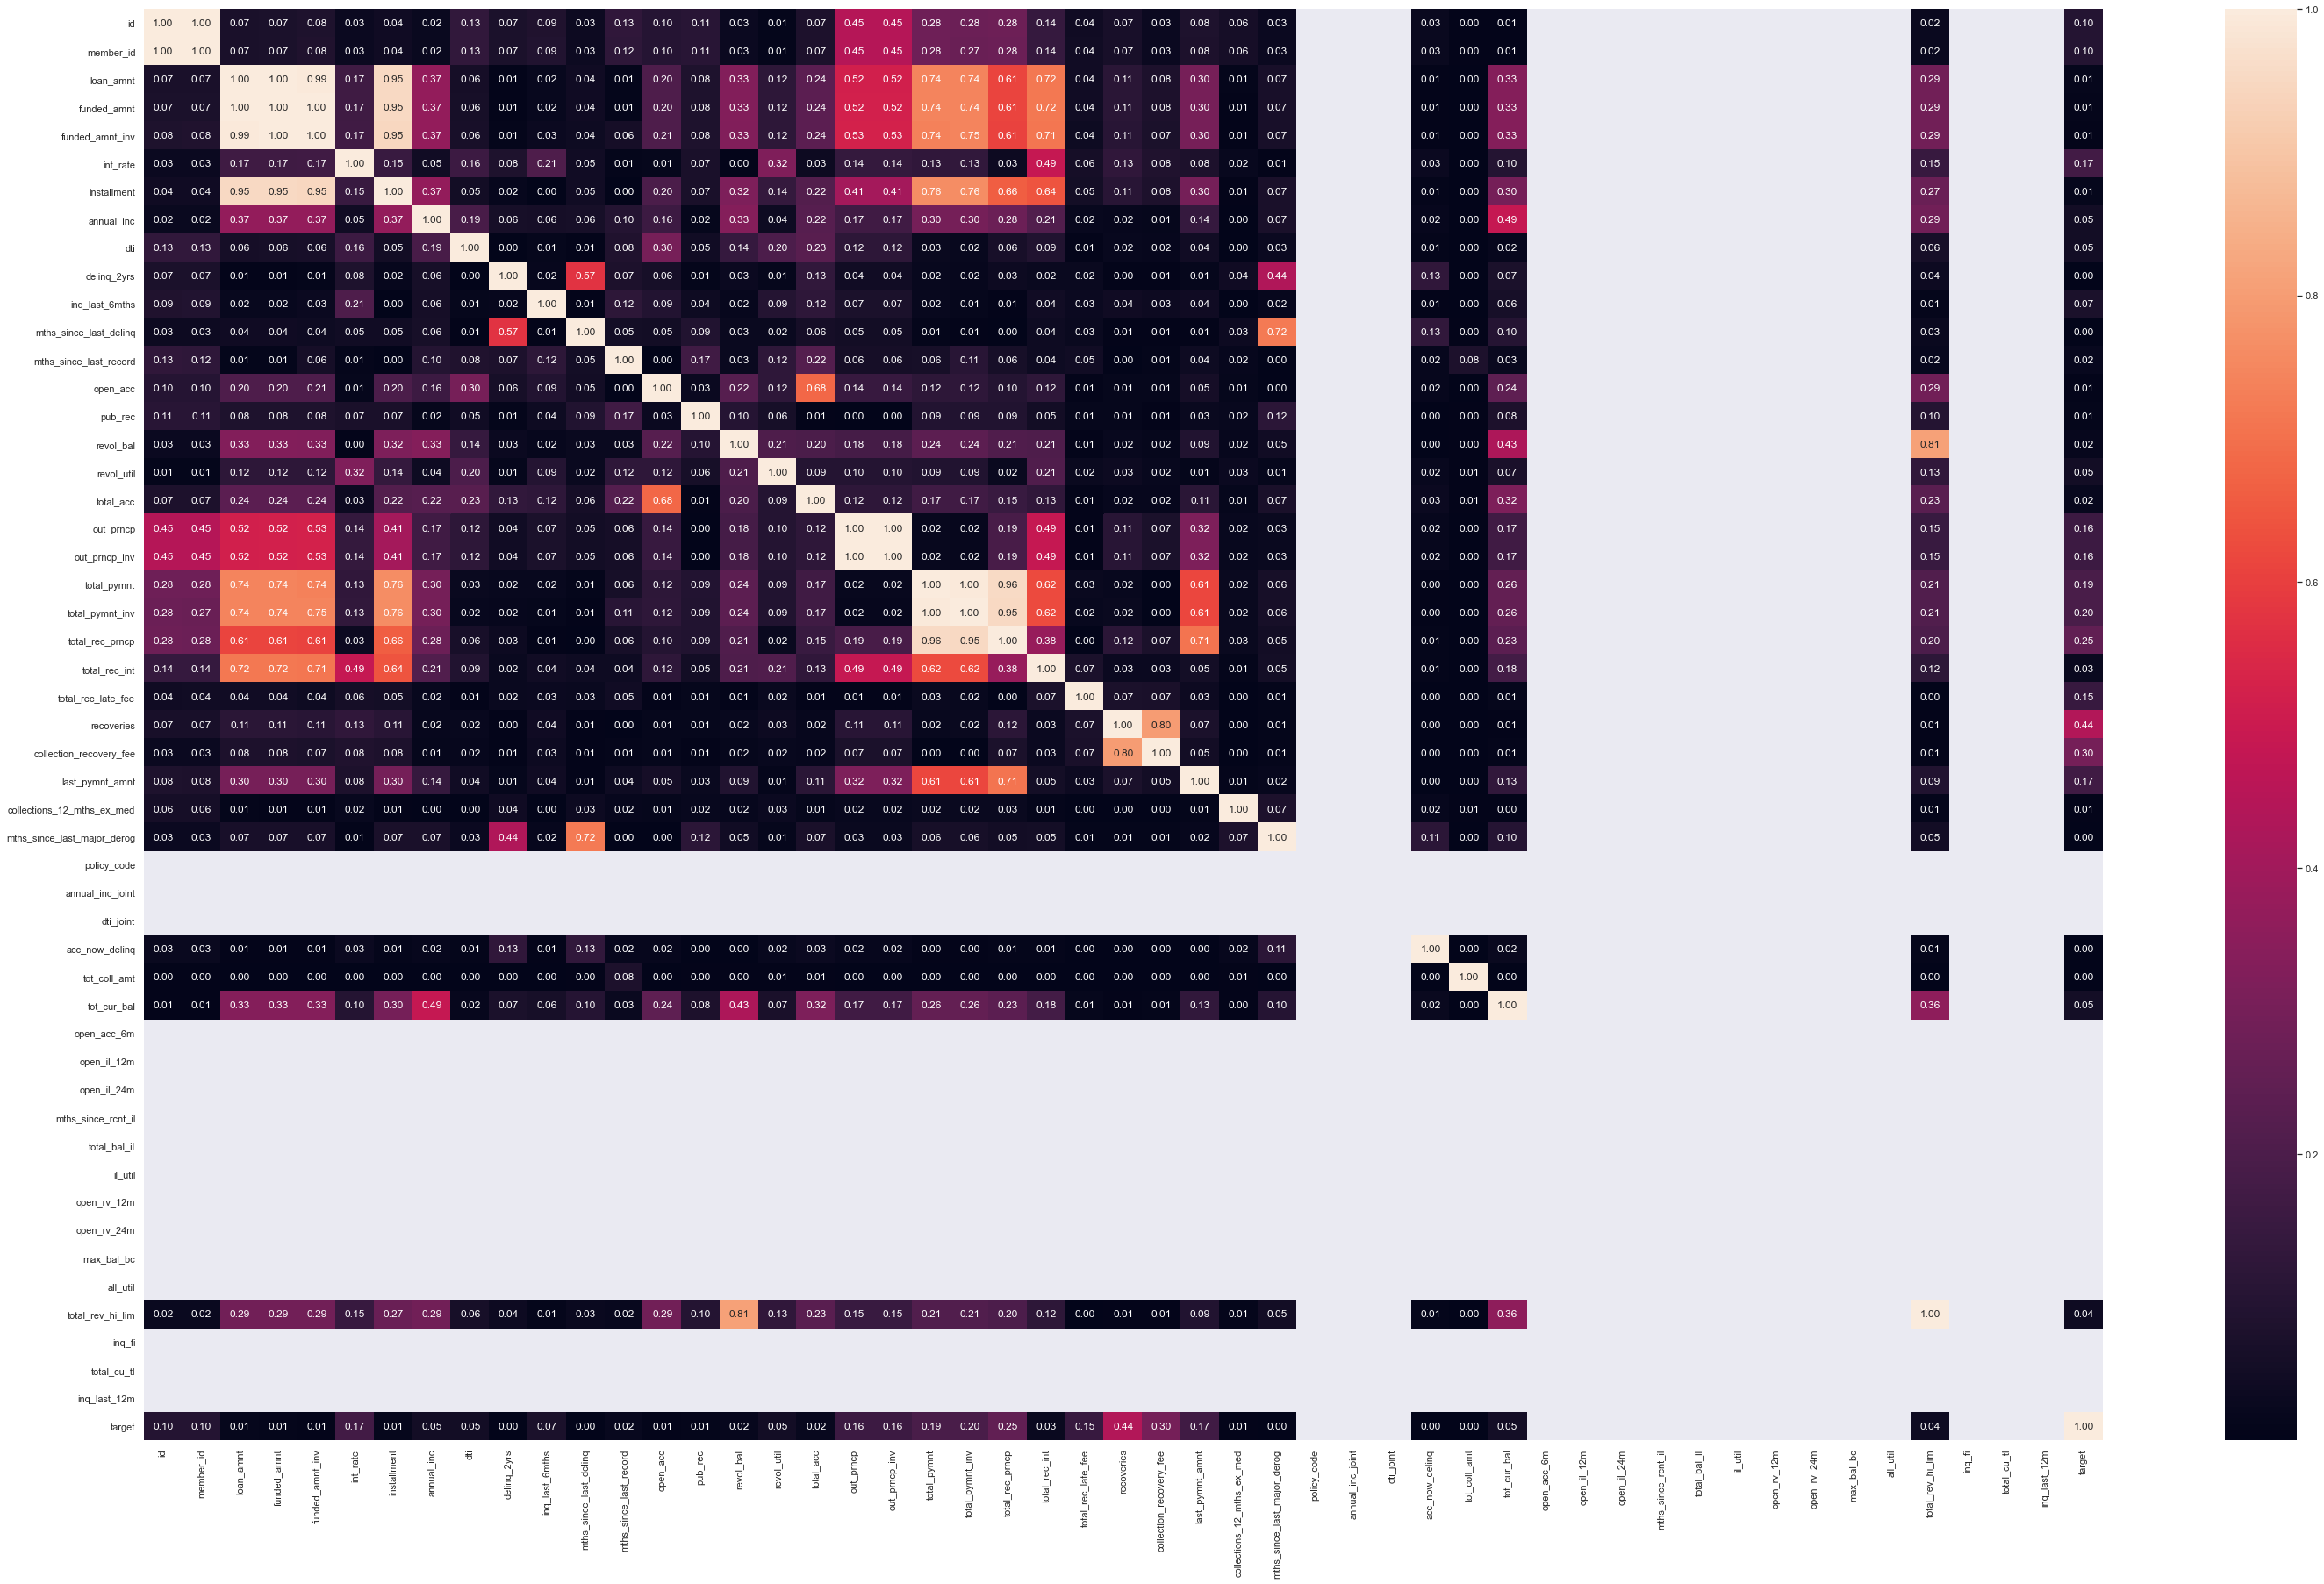

In [58]:
sns.set(rc={'figure.figsize':(50, 30)})
sns.heatmap(abs(data.corr()), annot=True, fmt='.2f')

In [59]:
# Удаление списка плохих атрибутов
bad_features = ['id', 
                'member_id', 
                
                'policy_code', 
                'annual_inc_joint', 
                'dti_joint', 
                
                'open_acc_6m',
                'open_il_12m',
                'open_il_24m',
                'mths_since_rcnt_il',
                'total_bal_il',
                'il_util',
                'open_rv_12m',
                'open_rv_24m',
                'max_bal_bc',
                'all_util',
                'inq_fi',
                'total_cu_tl',
                'inq_last_12m',
                
                'funded_amnt',
                'funded_amnt_inv',
                
                'total_pymnt',
                'total_pymnt_inv',
                
                'installment', # этот и выше - исходя из корреляций
                'issue_d', #месяц не важен
                
                'grade', #оставили sub_grade
                
                'emp_title', # строка
                'url', #строка
                'desc', #строка
                
                'title', #строка
                'zip_code', 
                
                'out_prncp_inv', 
                'total_pymnt_inv', #дубли
                
                'application_type', #строка консттанта
                'annual_inc_joint', #наны
                
                'pymnt_plan', # всего 9 y
                'recoveries',    #заглядываем в будущее
                'collection_recovery_fee',    #заглядываем в будущее
                'tot_coll_amt' ,#непонятно че это
                'collections_12_mths_ex_med', #непонятнооо 
                'mths_since_last_record' #так как фильтруем тех, у кого есть записи
                
               ]


# Добавляем в плохие атрибуты даты
bad_features = set(bad_features)
for col in data.select_dtypes(include='datetime64[ns]').columns:
    bad_features.add(col)
bad_features = list(bad_features)
# Удаляем из списка плохих атрибутов атрибут 'issue_d', так как это техническое поле
bad_features.remove('issue_d')
print(f"Количество плохих атрибутов: {len(bad_features)}")

# Список технических полей
tech_columns = ['id', 'member_id', 'issue_d', 'target']
print(f"Количество технических атрибутов: {len(tech_columns)}")

# Список категориальных атрибутов
category_features = []
for col in data.select_dtypes(include='object').columns:
    category_features.append(col)
category_features = list(set(category_features) - set(bad_features))
print(f"Количество категориальных атрибутов: {len(category_features)}")

# Список интервальных атрибутов
interrval_features = list(set(data.columns) - set(tech_columns) - set(category_features) - set(bad_features))
print(f"Количество интервальных атрибутов: {len(interrval_features)}")

# Список всех атрибутов: категориальные + интервальные
features = interrval_features + category_features
print(f"Общее количество атрибутов: {len(features)}")

Количество плохих атрибутов: 41
Количество технических атрибутов: 4
Количество категориальных атрибутов: 8
Количество интервальных атрибутов: 21
Общее количество атрибутов: 29


In [60]:
# plt.figure(figsize=(20, 50))
# for idx, col in enumerate(interrval_features):
#     plt.subplot(9, 3, idx+1)
#     plt.yscale('log')

#     plt.hist(data[col], 15)
#     plt.title(col)

## Task 1. Кодирование категориальных переменных

> Реализуйте функцию, которая кодирует категориальные переменные в датасете, используя LabelEncoding

> При реализации функции учтите следующее:
* В данном случае у нас нет необходимости делить выборку на train\test перед кодированием, поскольку все категориальные данные клиент выбирает из ограниченного списка, поэтому кодирование производим на всей выборке до деления на train\test

> Описание функции:
* На вход принимает:
1. Датасет со всеми атрибутами, техническими столбцами и целевым событием
2. Список категориальных атрибутов
* Возвращает следующее:
1. Датасет, в котором все категориальные переменные закодированы, при этом имена столбцов с категориальными переменными не меняются
2. Словарь, ключами которого являются названия столбцов категориальных переемнных, а значениями np.array с двумя столбцами:
* Первый столбец - значение категориального атрибута
* Второй столбец - численное значение, соответствующее значению категориального атрибута


In [61]:
def prepare_categorial_attributes(data_, category_columns_):
    df = data_.copy()
    column_encodings = {}
    for col in category_columns_:
        enc = LabelEncoder()
        df[col] = enc.fit_transform(df[col]).astype('int64')

        keys = enc.classes_
        vals = enc.transform(keys)
        column_encodings[col] = np.array([keys, vals ]).T
    return df, column_encodings

In [62]:
# Проверяем реализацию функции
assert_data_transformed, assert_dct_cat_labels = prepare_categorial_attributes(data_ = assert_data, category_columns_ = assert_category_features)

assert assert_data_transformed.shape == assert_data.shape
assert sum(assert_data_transformed[assert_category_features].dtypes == 'int64') == len(assert_category_features)
assert len(assert_dct_cat_labels) == len(assert_category_features)
for col in assert_category_features:
    assert assert_dct_cat_labels[col].shape == (assert_data[col].nunique(), 2)

In [63]:
# Применяем функцию к целевой таблице
data_transformed, dct_cat_labels = prepare_categorial_attributes(data_ = data, category_columns_ = category_features)

# Формирование train и test dataframes для моделирования

Отобразим зависимость доли популяции и уровня дефолта от даты подачи заявки

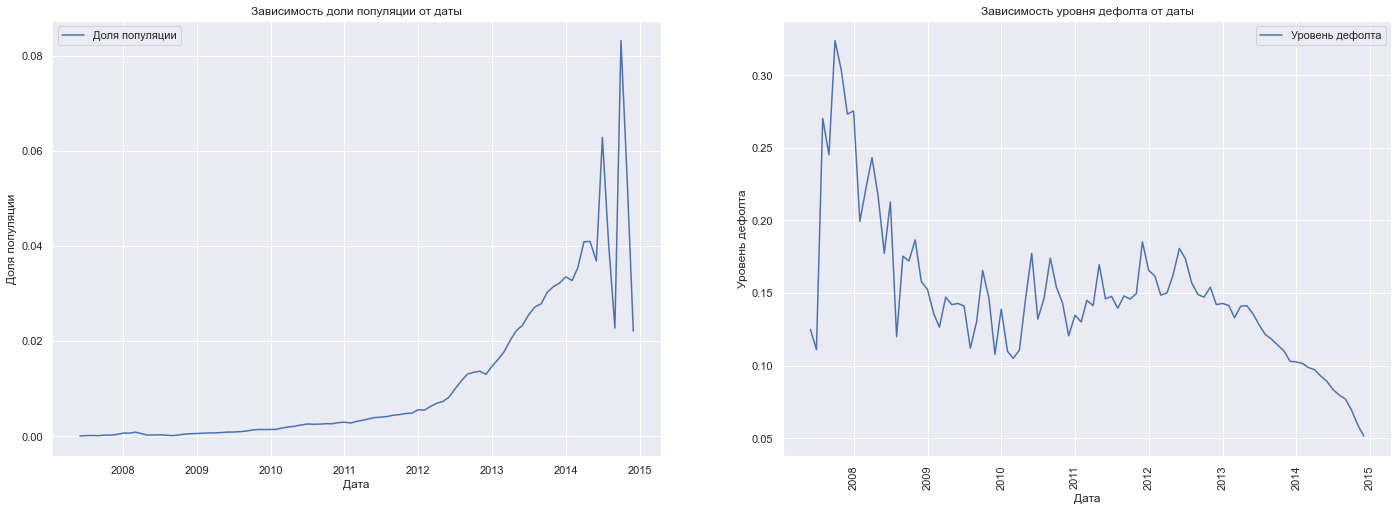

In [64]:
# Функция визуализации доли популяции и уровня дефолта
def draw_pop_def_rate(data_):
    temp = data_.groupby('issue_d').agg({'id' : 'count', 'target' : 'mean'})

    # Визуализация
    fig = plt.figure(figsize=(24,8))
    ax_1 = fig.add_subplot(1, 2, 1)
    ax_2 = fig.add_subplot(1, 2, 2)

    ax_1.set_title('Зависимость доли популяции от даты')
    ax_1.plot(temp.index, temp['id']/temp['id'].sum(), label='Доля популяции')
    plt.xticks( rotation=90)
    ax_1.set_xlabel('Дата')
    ax_1.set_ylabel('Доля популяции')
    ax_1.legend()

    ax_2.set_title('Зависимость уровня дефолта от даты')
    ax_2.plot(temp.index, temp['target'], label='Уровень дефолта')
    plt.xticks(rotation=90)
    ax_2.set_xlabel('Дата')
    ax_2.set_ylabel('Уровень дефолта')
    ax_2.legend()

    plt.show()


draw_pop_def_rate(data_ = data_transformed.copy())

# Task 2. Определение границы разделения на train/test

Поскольку наша модель будет применяться в будущем на новых клиентах, то деление на train\test будем производить только по временной метке. 

> Реализуйте функцию, которая для каждого возможного месяца деления на train\test возвращает долю популяции и уровень дефолта в каждой выборке

> Описание функции:
* На вход принимает:
1. Датасет со всеми атрибутами, техническими столбцами и целевым событием
* Возвращает pandas DataFrame со следующими столбцами:
1. month - месяц деления на train\test
2. qnt_rate_train - доля популяции train выборки
3. qnt_rate_test - доля популяции test выборки
4. default_rate_train - уровень дефолта train выборки
5. default_rate_test - уровень дефолта test выборки

In [65]:
def possible_train_test_division(data_):
    data_['issue_d'] = pd.to_datetime(data_['issue_d'])
    df = pd.DataFrame(columns=['month', 'qnt_rate_train', 'qnt_rate_test', 'default_rate_train', 'default_rate_test'])
    
    df['month'] = data_['issue_d'].unique()
    
    qnt_rate_train = []
    qnt_rate_test = []
    default_rate_train = []
    default_rate_test=[]
    for m in df['month']:
        train, test = data_[data_['issue_d'] <= m], data_[data_['issue_d'] > m]
        qnt_rate_train.append(len(train)/len(data_))
        qnt_rate_test.append(len(test)/len(data_))
        default_rate_train.append(train['target'].sum()/len(train))
        default_rate_test.append(test['target'].sum()/len(test))
    
    df['qnt_rate_train'] = qnt_rate_train
    df['qnt_rate_test'] = qnt_rate_test
    df['default_rate_train'] = default_rate_train
    df['default_rate_test'] = default_rate_test
        
    return df.fillna(0)

In [66]:
# Проверяем реализацию функции
assert_possible_division_dataset = possible_train_test_division(data_ = assert_data_transformed.copy())


assert assert_possible_division_dataset.shape == (60, 5)
assert set(assert_possible_division_dataset.columns) == {'default_rate_test', 'default_rate_train', 'month', 'qnt_rate_test', 'qnt_rate_train'}
assert round(assert_possible_division_dataset['default_rate_test'].sum(), 5) == 32.10218
assert round(assert_possible_division_dataset['default_rate_train'].sum(), 5) == 28.79368
assert round(assert_possible_division_dataset['qnt_rate_test'].sum(), 5) == 29.5
assert round(assert_possible_division_dataset['qnt_rate_train'].sum(), 5) == 30.5

In [67]:
# Применяем функцию к целевой таблице
possible_division_dataset = possible_train_test_division(data_ = data_transformed.copy())

Визуализируем результаты возможных разбиений

In [68]:
def make_test_flg(data_, part):
    month_list = list(data_.sort_values('issue_d')['issue_d'].drop_duplicates())
    month_num = round(part * len(month_list))
    data_['test_flg'] = np.where(data_['issue_d'] > month_list[month_num], 1, 0)
    print(f'Месяц деления на train test: {month_list[month_num]}')
    return data_

In [69]:
def draw_possible_train_test_split(data_, possible_division_dataset):

    # Проставляем флаг тестовой выборки
    month_split = data_[data_['test_flg']==1]['issue_d'].min()

    # Визуализация
    fig = plt.figure(figsize=(24,8))
    ax_1 = fig.add_subplot(1, 2, 1)
    ax_2 = fig.add_subplot(1, 2, 2)

    ax_1.set_title('Доля популяции train и test выборок')
    ax_1.plot(possible_division_dataset['month'], possible_division_dataset['qnt_rate_train'], label='train')
    ax_1.plot(possible_division_dataset['month'], possible_division_dataset['qnt_rate_test'], label='test')
    ax_1.axvline(month_split, color='red', ls='--', label=f'test split')
    plt.xticks( rotation=90)
    ax_1.set_xlabel('Дата разделения на train/test')
    ax_1.set_ylabel('Доля популяции')
    ax_1.legend()

    ax_2.set_title('Уровень дефолта train и test выборок')
    ax_2.plot(possible_division_dataset['month'], possible_division_dataset['default_rate_train'], label='train')
    ax_2.plot(possible_division_dataset['month'], possible_division_dataset['default_rate_test'], label='test')
    ax_2.axvline(month_split, color='red', ls='--', label=f'test split')
    plt.xticks(rotation=90)
    ax_2.set_xlabel('Дата разделения на train/test')
    ax_2.set_ylabel('Уровень дефолта')
    ax_2.legend()

    plt.show()

In [94]:
data_transformed.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',

Месяц деления на train test: 2014-04-01 00:00:00


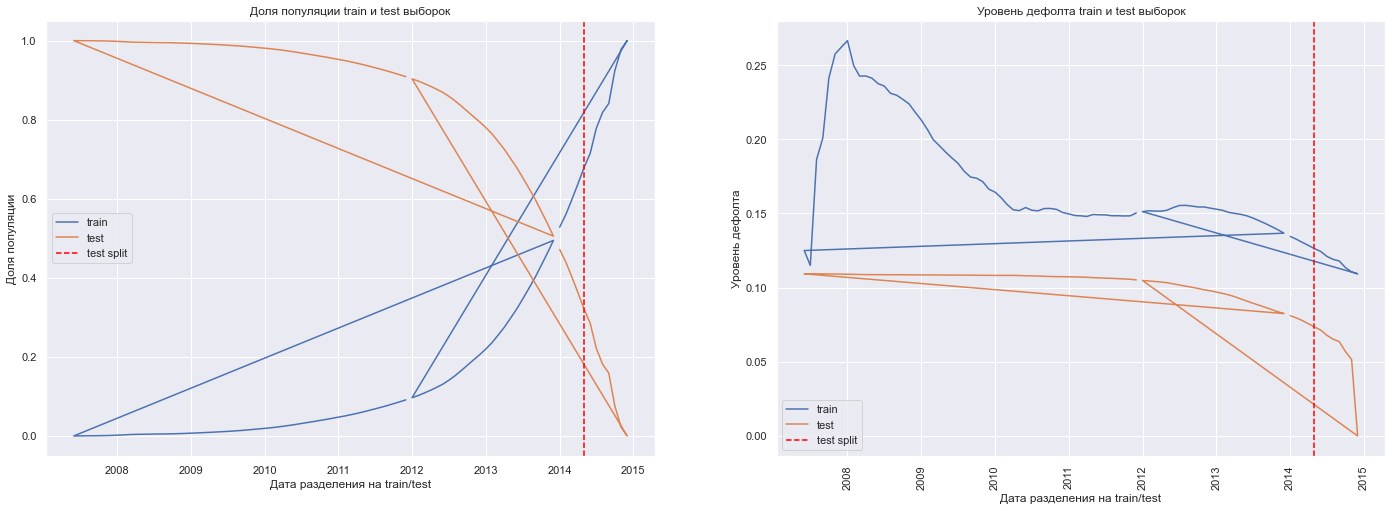

In [70]:
part = 0.9
data_transformed = make_test_flg(data_ = data_transformed, part = part)
draw_possible_train_test_split(data_ = data_transformed, 
                               possible_division_dataset = possible_division_dataset.copy())

In [71]:
# Информация о разделении на train и test
def information_train_test(data_):
    temp = data_.groupby('test_flg').agg({'id' : 'count', 'target' : ['mean', 'sum']})
    temp.columns = ['Кол-во наблюдений', 'Уровень дефолта', 'Кол-во дефолтных наблюдений']
    temp['Доля популяции'] = temp['Кол-во наблюдений'] / data_.shape[0]
    return temp

data_transformed = make_test_flg(data_ = data_transformed, part = part)
information_train_test(data_ = data_transformed.copy())    

Месяц деления на train test: 2014-04-01 00:00:00


,Кол-во наблюдений,Уровень дефолта,Кол-во дефолтных наблюдений,Доля популяции
test_flg,,,,
0,297138,0.128452,38168,0.637245
1,169147,0.075674,12800,0.362755


## TASK 2.1 Определение границ

Исходя из графика распределения доли популяции и помесячного дефолта выберете оптимальные границы выборки для разработки и выборки для применения.

* start_date - дата начала выборки
* end_date - конец выборки
* test_start_date - дата деления на train и test

In [72]:
data_transformed['issue_d'].max()

Timestamp('2014-12-01 00:00:00')

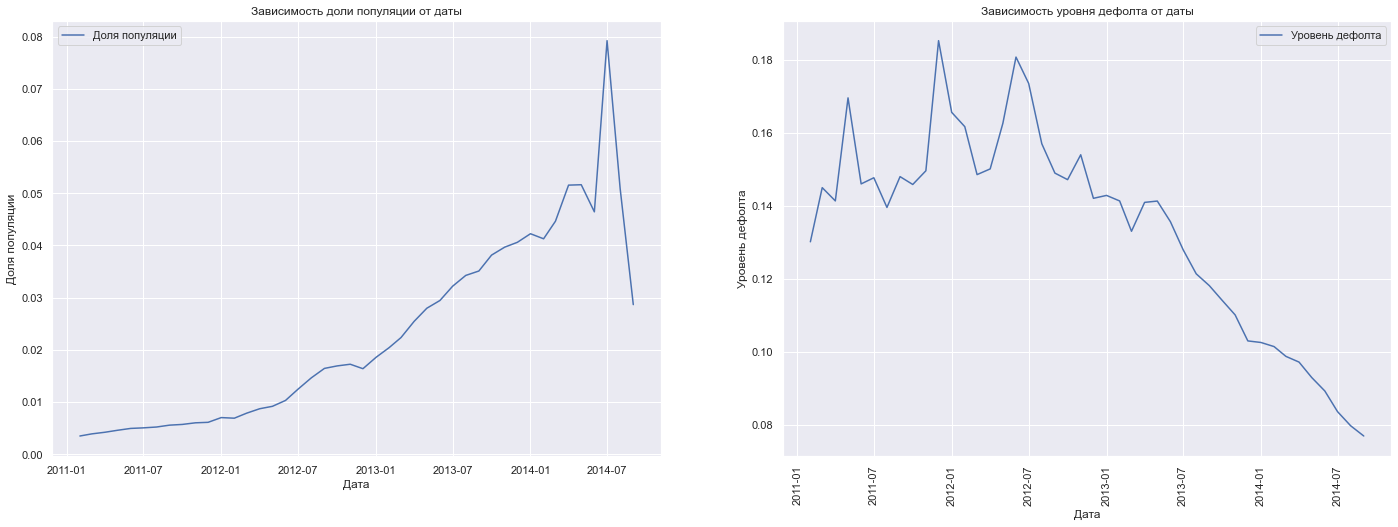

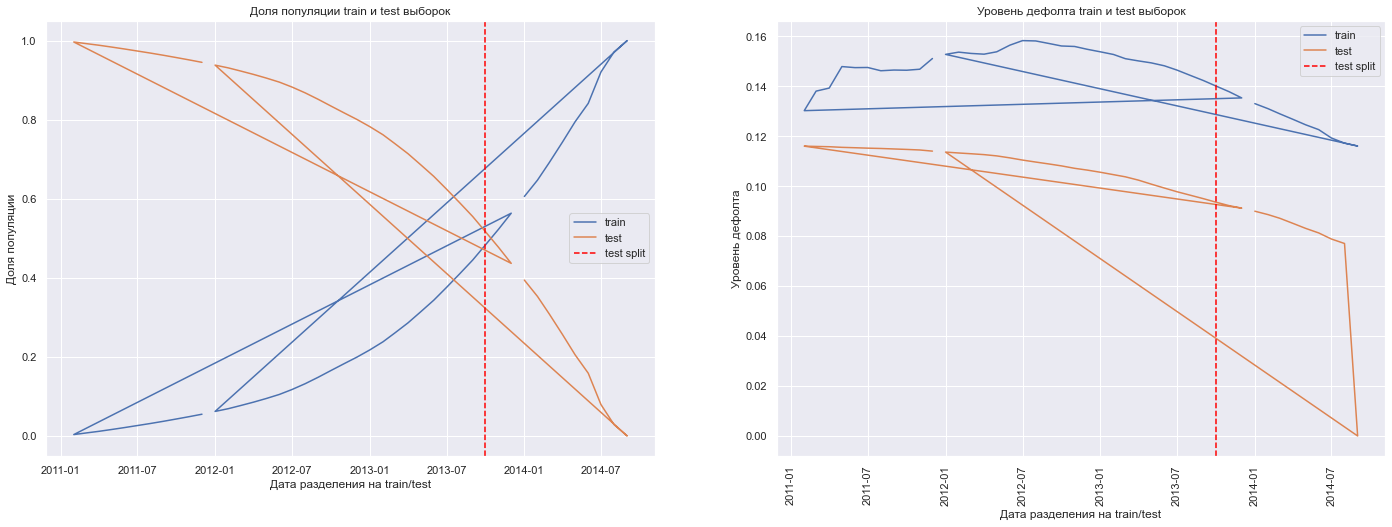

,Кол-во наблюдений,Уровень дефолта,Кол-во дефолтных наблюдений,Доля популяции
test_flg,,,,
0,164653,0.142287,23428,0.445071
1,205295,0.094995,19502,0.554929


In [73]:
start_date = pd.to_datetime('2011-01-01 00:00:00')
end_date =  pd.to_datetime('2014-10-01 00:00:00')
test_start_date = pd.to_datetime('2013-10-01 00:00:00')


data_transformed_short = data_transformed[(data_transformed['issue_d'] > start_date) & \
                                          (data_transformed['issue_d'] < end_date)
                                          ]

# Доля популяции и уровень дефолта
draw_pop_def_rate(data_ = data_transformed_short.copy())

# Деление на train и test
data_transformed_short['test_flg'] = np.where(data_transformed_short['issue_d'] >= test_start_date, 1, 0)
possible_division_dataset_new = possible_train_test_division(data_ = data_transformed_short.copy())
draw_possible_train_test_split(data_ = data_transformed_short, 
                               possible_division_dataset = possible_division_dataset_new)

# Информация о разделении на train и test
information_train_test(data_ = data_transformed_short.copy()) 

Убедитесь, что в выборках достаточное количество наблюдений и поясните ваш выбор границ выборок.

In [74]:
data_transformed = data_transformed_short.copy()

Визуализируем также при выбранном разделении на train\test количество дефолтных, количество недефолтных наблюдений и уровень дефолта по годам, на train и test выборках

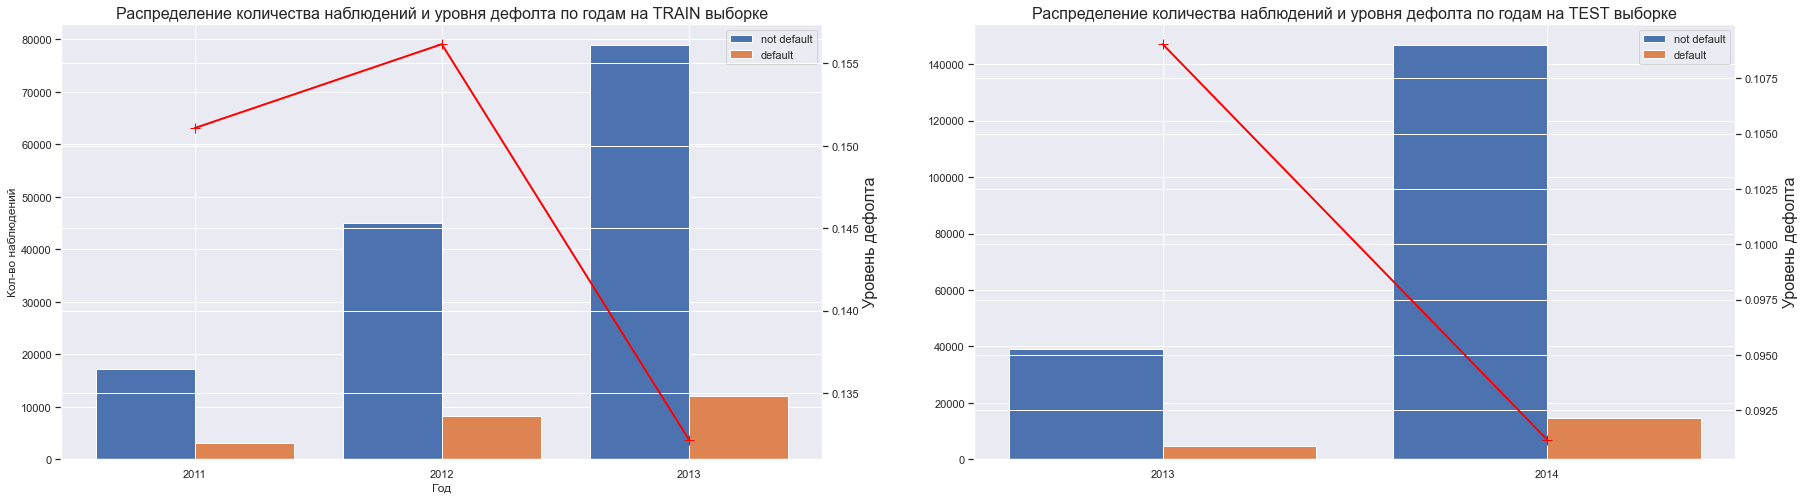

In [75]:
# Распределение количества наблюдений по годам
temp_data = data_transformed.copy()
temp_data['year'] = temp_data['issue_d'].apply(lambda x: x.year)
temp_train = temp_data[temp_data['test_flg']==0].copy()
temp_test = temp_data[temp_data['test_flg']==1].copy()
train_tar0 = temp_train[temp_train['target']==0].groupby('year').agg({'id' : 'count', 'target' : 'mean'})
train_tar1 = temp_train[temp_train['target']==1].groupby('year').agg({'id' : 'count', 'target' : 'mean'})
test_tar0 = temp_test[temp_test['target']==0].groupby('year').agg({'id' : 'count', 'target' : 'mean'})
test_tar1 = temp_test[temp_test['target']==1].groupby('year').agg({'id' : 'count', 'target' : 'mean'})


width = 0.4
fig = plt.figure(figsize=(30,8))

ax_1 = fig.add_subplot(1, 2, 1)
ax_2 = fig.add_subplot(1, 2, 2)

ind = np.arange(len(train_tar0.index))
ax_1.set_title('Распределение количества наблюдений и уровня дефолта по годам на TRAIN выборке', fontsize=16)
ax_1.set(xticks=ind + 0.5*width, xticklabels=train_tar0.index)
ax_1.bar(ind, train_tar0['id'], width, label='not default')
ax_1.bar(ind + width, train_tar1['id'], width, label='default')
ax_1.set_ylabel('Кол-во наблюдений')
ax_1.set_xlabel('Год')
ax_1.legend()

ax_1_ = ax_1.twinx()
ax_1_.plot(ind + 0.5*width, temp_train.groupby('year')['target'].mean(), '+-', linewidth=2, markersize=10, color='red')
ax_1_.set_ylabel('Уровень дефолта', fontsize=16)


ind = np.arange(len(test_tar0.index))
ax_2.set_title('Распределение количества наблюдений и уровня дефолта по годам на TEST выборке', fontsize=16)
ax_2.set(xticks=ind + 0.5*width, xticklabels=test_tar0.index)
ax_2.bar(ind, test_tar0['id'], width, label='not default')
ax_2.bar(ind + width, test_tar1['id'], width, label='default')
ax_2.legend()

ax_2_ = ax_2.twinx()
ax_2_.plot(ind + 0.5*width, temp_test.groupby('year')['target'].mean(), '+-', linewidth=2, markersize=10, color='red')
ax_2_.set_ylabel('Уровень дефолта', fontsize=16)

plt.show()

In [76]:
temp = temp_train.groupby('year').agg({'target':'mean', 'id':'count'}).merge(train_tar1['id'], how='left', left_index=True, right_index=True).merge(train_tar0['id'], how='left', left_index=True, right_index=True)
temp.columns = ['Уровень дефолта', 'Количество наблюдений', 'Количество дефолтных наблюдений', 'Количество недефолтных наблюдений']
temp

,Уровень дефолта,Количество наблюдений,Количество дефолтных наблюдений,Количество недефолтных наблюдений
year,,,,
2011,0.151074,20341,3073,17268
2012,0.156164,53367,8334,45033
2013,0.132179,90945,12021,78924


# Профилирование атрибутов

In [77]:
# Инофрмация об атрибутах на TRAIN 
data_transformed[data_transformed['test_flg']==0][features].describe().T

,count,mean,std,min,25%,50%,75%,max
total_rec_prncp,164653.0,11124.055694,7471.856245,0.00,5658.56,9731.73,15000.00,3.500003e+04
pub_rec,164653.0,0.088629,0.355285,0.00,0.00,0.00,0.00,5.400000e+01
total_rev_hi_lim,116571.0,29852.470829,40506.879070,0.00,14000.00,22900.00,37100.00,9.999999e+06
last_pymnt_amnt,164653.0,3627.530266,5643.116741,0.00,343.39,679.32,4867.36,3.611520e+04
total_rec_late_fee,164653.0,0.779045,5.641218,0.00,0.00,0.00,0.00,2.867476e+02
revol_bal,164653.0,15954.503914,18782.361137,0.00,6749.00,12077.00,20336.00,2.568995e+06
total_rec_int,164653.0,3035.188308,3060.818233,0.00,1055.80,2022.19,3800.41,2.420562e+04
loan_amnt,164653.0,13987.633235,8146.497997,1000.00,8000.00,12000.00,19650.00,3.500000e+04
out_prncp,164653.0,1476.857841,3703.327756,0.00,0.00,0.00,604.46,2.544911e+04
delinq_2yrs,164653.0,0.212611,0.654983,0.00,0.00,0.00,0.00,2.900000e+01


In [78]:
# Инофрмация об атрибутах на TEST 
data_transformed[data_transformed['test_flg']==1][features].describe().T

,count,mean,std,min,25%,50%,75%,max
total_rec_prncp,205295.0,8222.310224,6644.962528,0.0,3632.075,6104.06,10503.525,35000.00
pub_rec,205295.0,0.207993,0.589214,0.0,0.000,0.00,0.000,63.00
total_rev_hi_lim,205295.0,29965.943515,29054.297056,0.0,13300.000,22600.00,37600.000,1998700.00
last_pymnt_amnt,205295.0,3161.739866,5769.858537,0.0,314.670,524.48,2585.320,35757.36
total_rec_late_fee,205295.0,0.510356,4.762604,0.0,0.000,0.00,0.000,358.68
revol_bal,205295.0,16100.873114,19439.456838,0.0,6503.000,11783.00,20262.500,1746716.00
total_rec_int,205295.0,2574.289443,2220.787607,0.0,1018.430,1881.68,3421.580,17803.28
loan_amnt,205295.0,14829.268613,8361.502730,1000.0,8400.000,13000.00,20000.000,35000.00
out_prncp,205295.0,5682.463776,6546.083895,0.0,0.000,3619.53,9136.550,31181.40
delinq_2yrs,205295.0,0.332599,0.872281,0.0,0.000,0.00,0.000,22.00


In [79]:
# Наблюдаем пустые атрибуты
# Обновим список bad_features и списки: category_features и interval_features
empty_columns = []
for col in features:
    if str(data_transformed[col].mean()) == 'nan':
        empty_columns.append(col)
bad_features = bad_features + empty_columns
print(f"Количество плохих атрибутов: {len(bad_features)}")

# Список категориальных атрибутов
category_features = list(set(category_features) - set(bad_features))
print(f"Количество категориальных атрибутов: {len(category_features)}")

# Список интервальных атрибутов
interrval_features = list(set(data.columns) - set(tech_columns) - set(category_features) - set(bad_features))
print(f"Количество интервальных атрибутов: {len(interrval_features)}")

# Список всех атрибутов: категориальные + интервальные
features = interrval_features + category_features
print(f"Общее количество атрибутов: {len(features)}")

Количество плохих атрибутов: 41
Количество категориальных атрибутов: 8
Количество интервальных атрибутов: 21
Общее количество атрибутов: 29


Посмотрим на распределение атрибутов для дефолтных наблюдений и недефолтных наблюдений

Отображение распределений для атрибута: total_rec_prncp


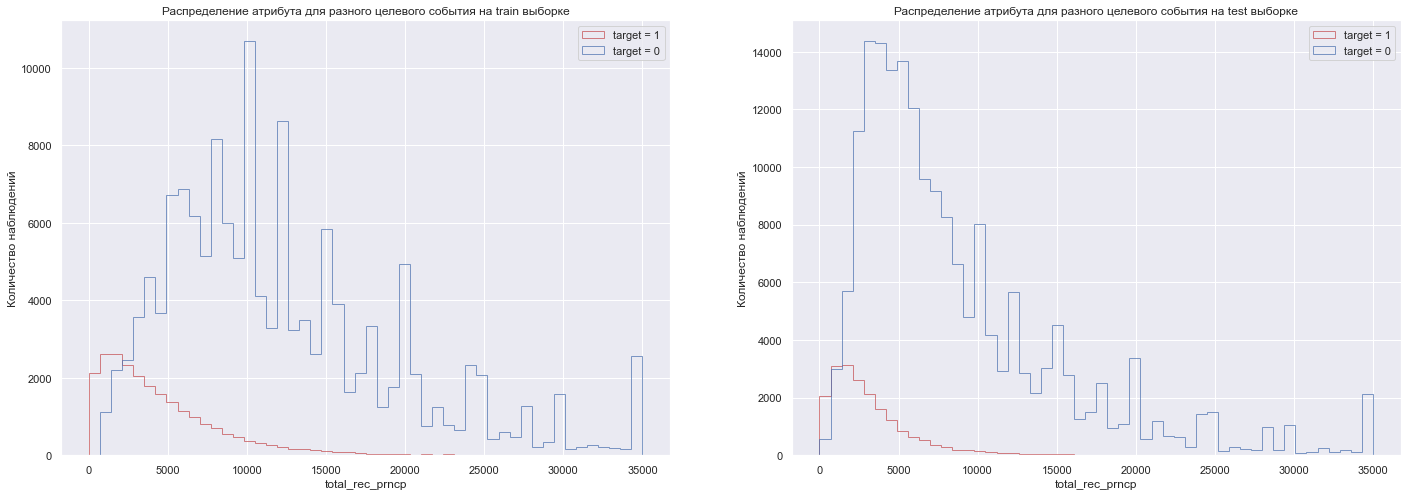


Отображение распределений для атрибута: pub_rec


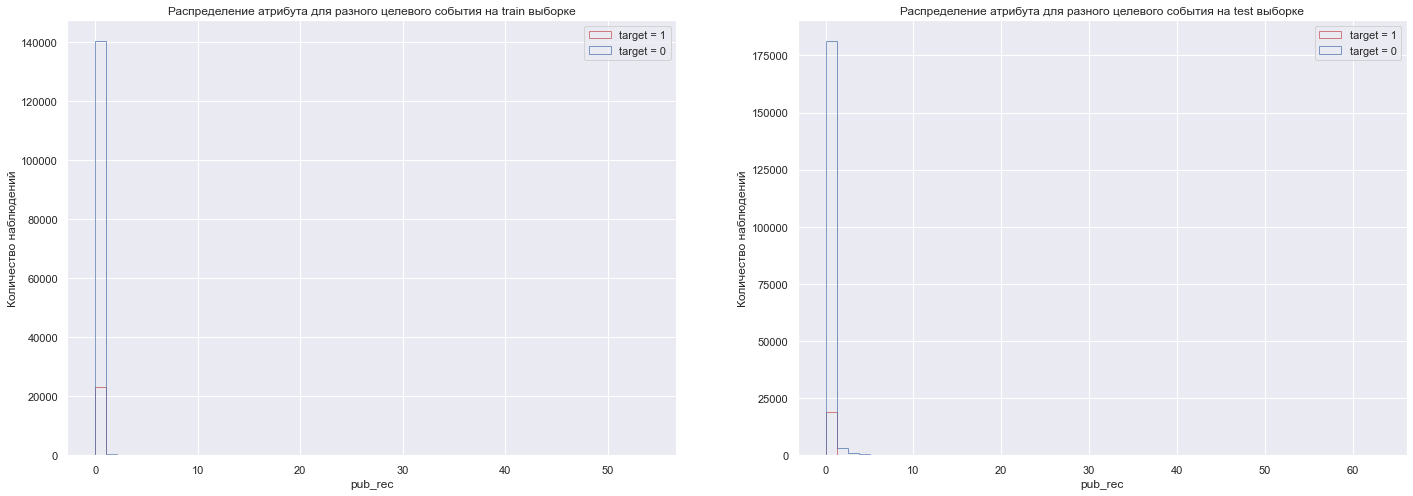


Отображение распределений для атрибута: total_rev_hi_lim


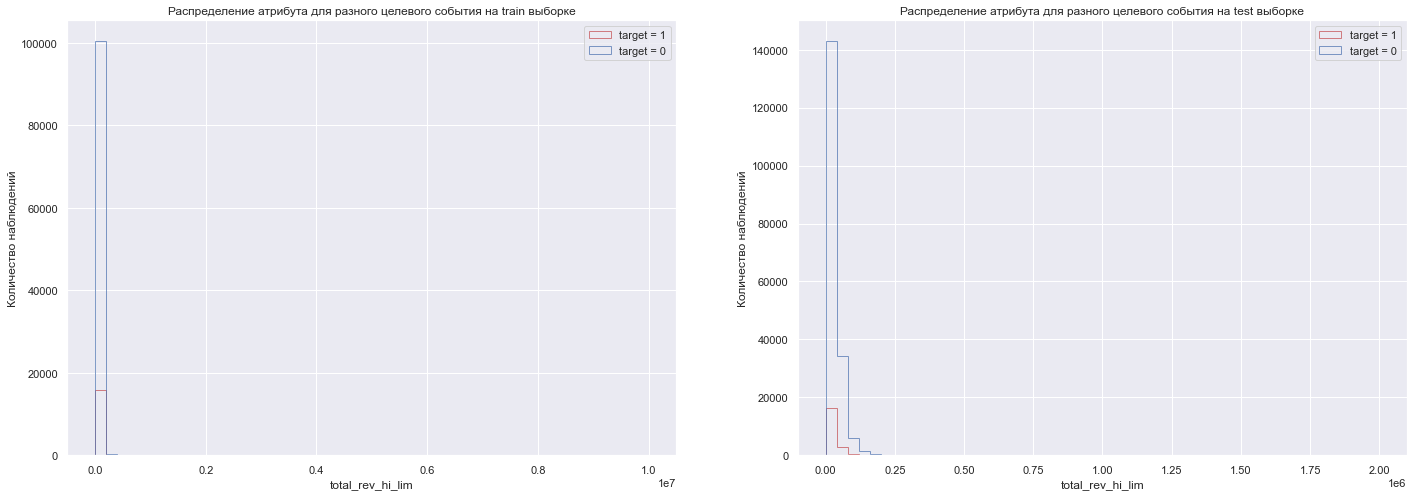


Отображение распределений для атрибута: last_pymnt_amnt


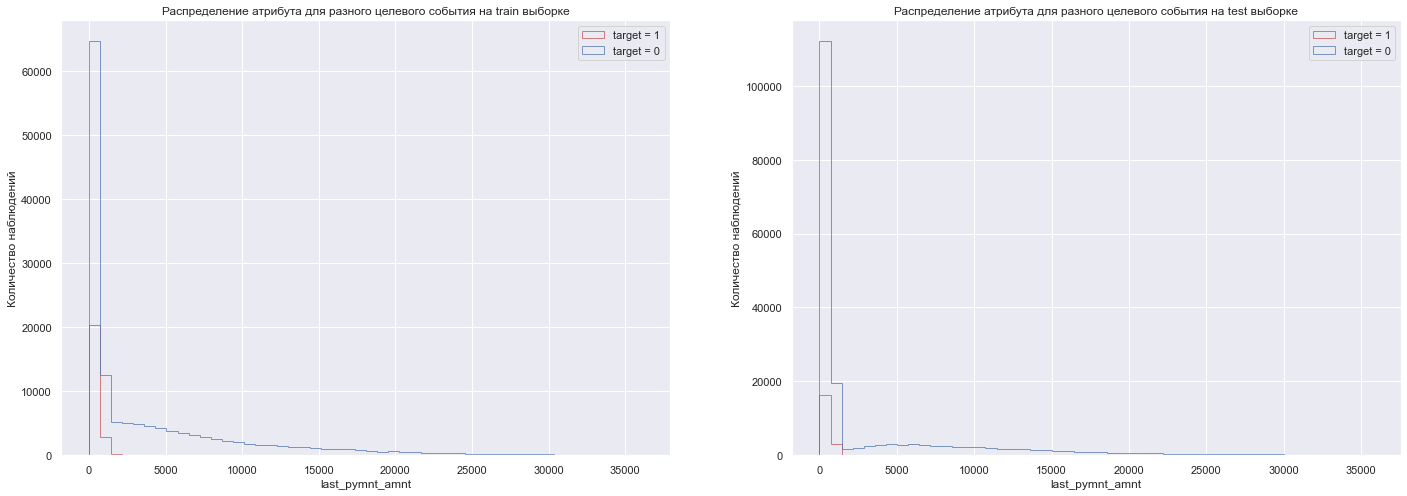


Отображение распределений для атрибута: total_rec_late_fee


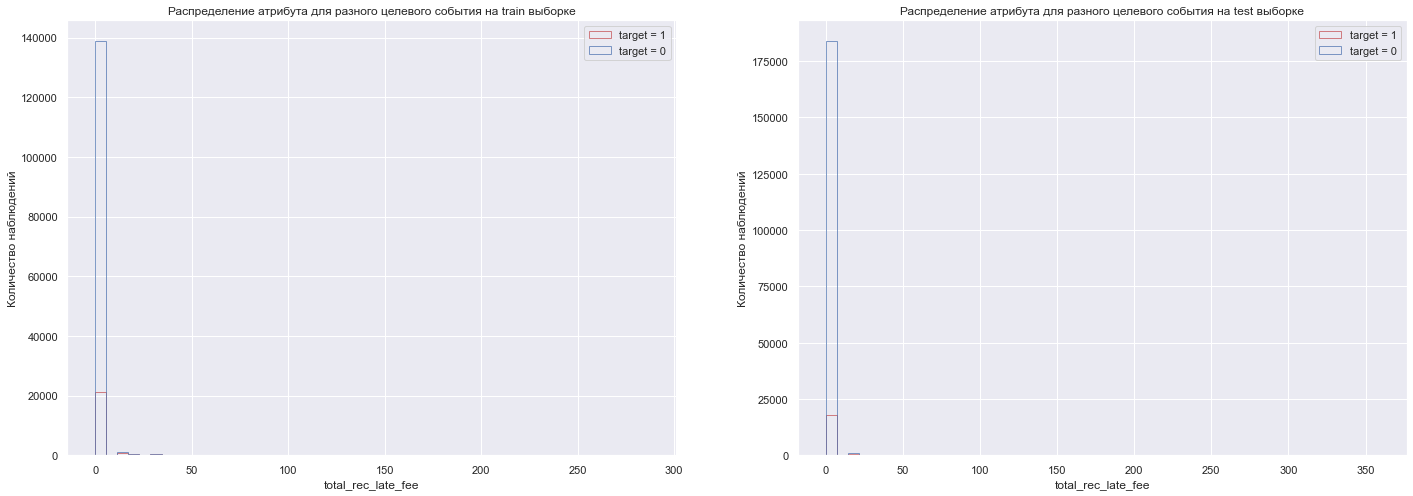


Отображение распределений для атрибута: revol_bal


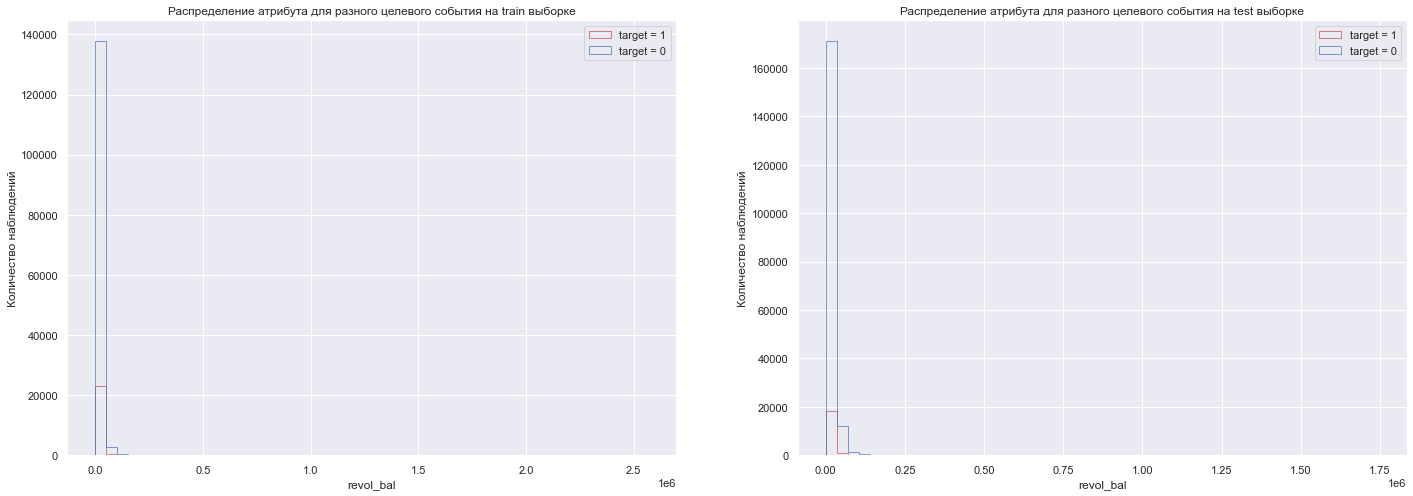


Отображение распределений для атрибута: total_rec_int


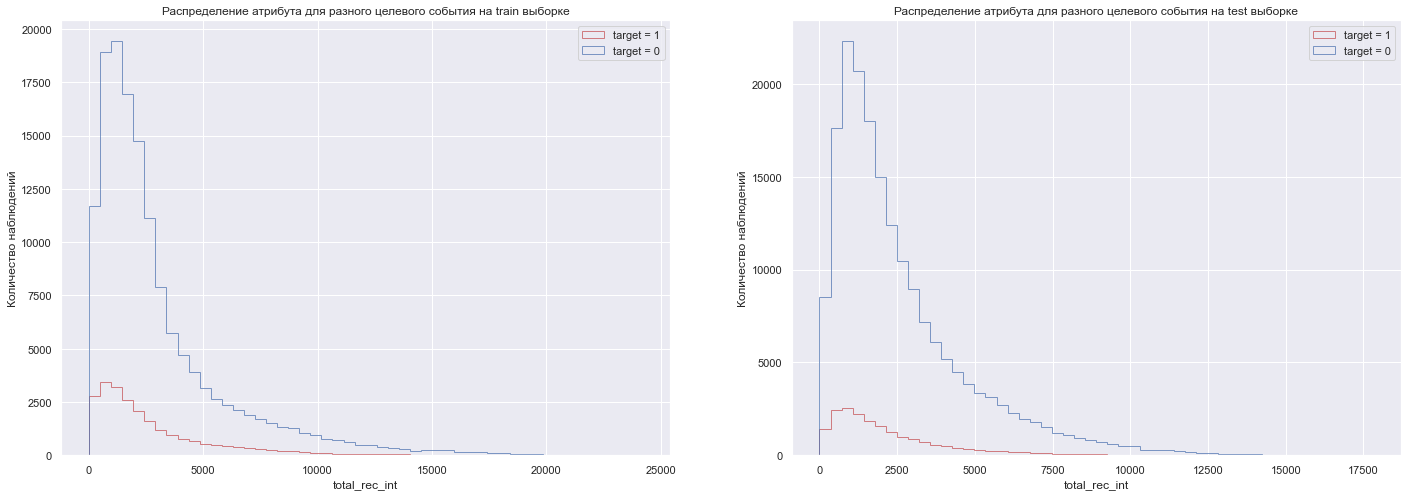


Отображение распределений для атрибута: loan_amnt


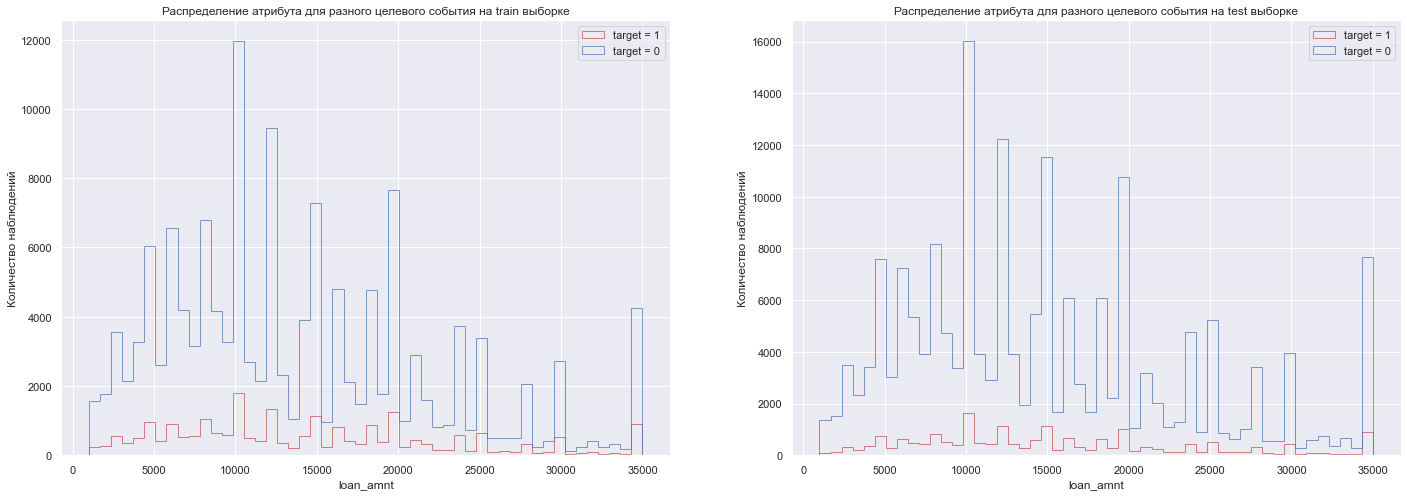


Отображение распределений для атрибута: out_prncp


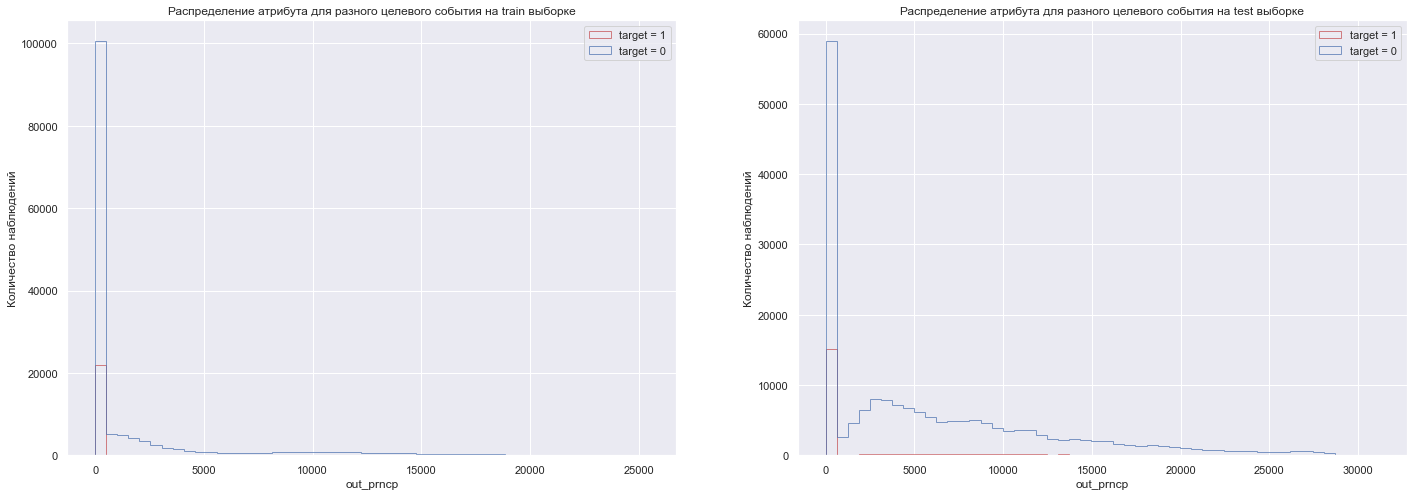


Отображение распределений для атрибута: delinq_2yrs


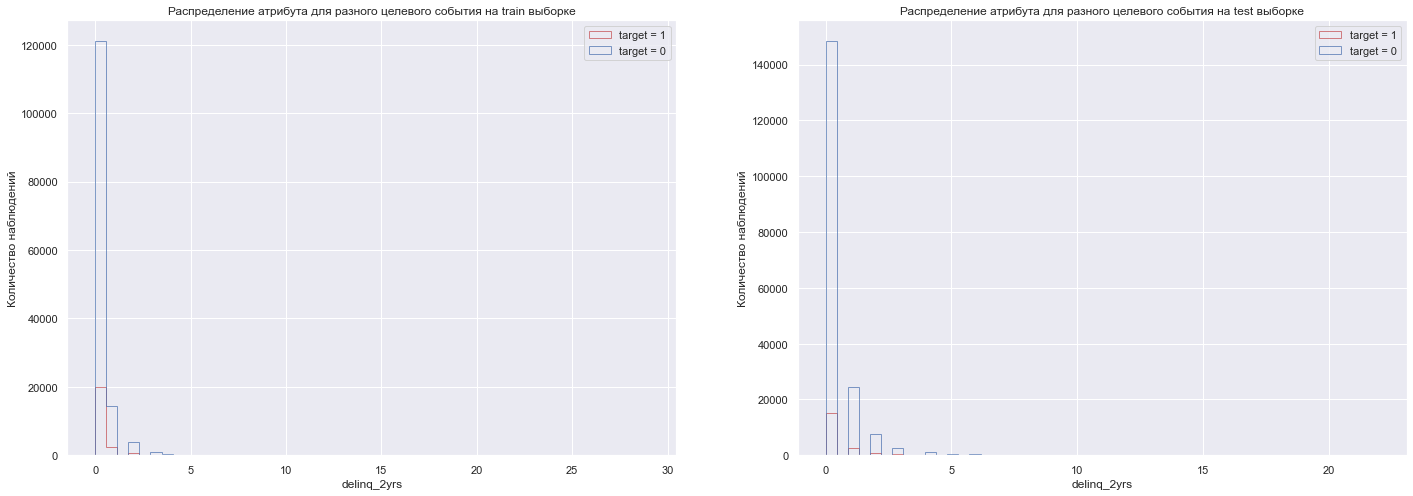


Отображение распределений для атрибута: tot_cur_bal


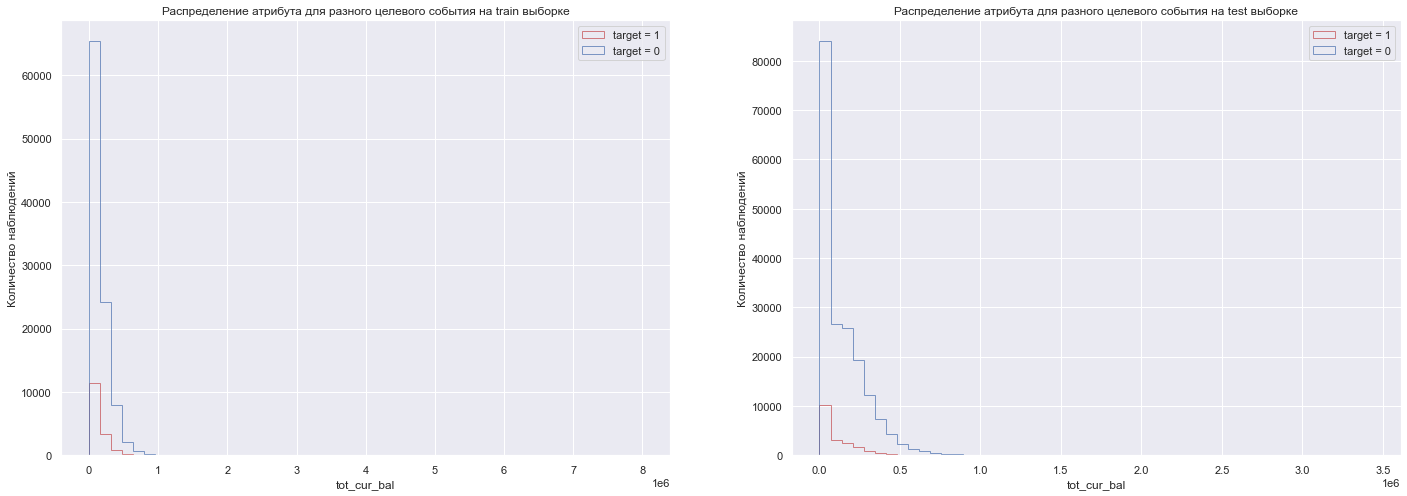


Отображение распределений для атрибута: annual_inc


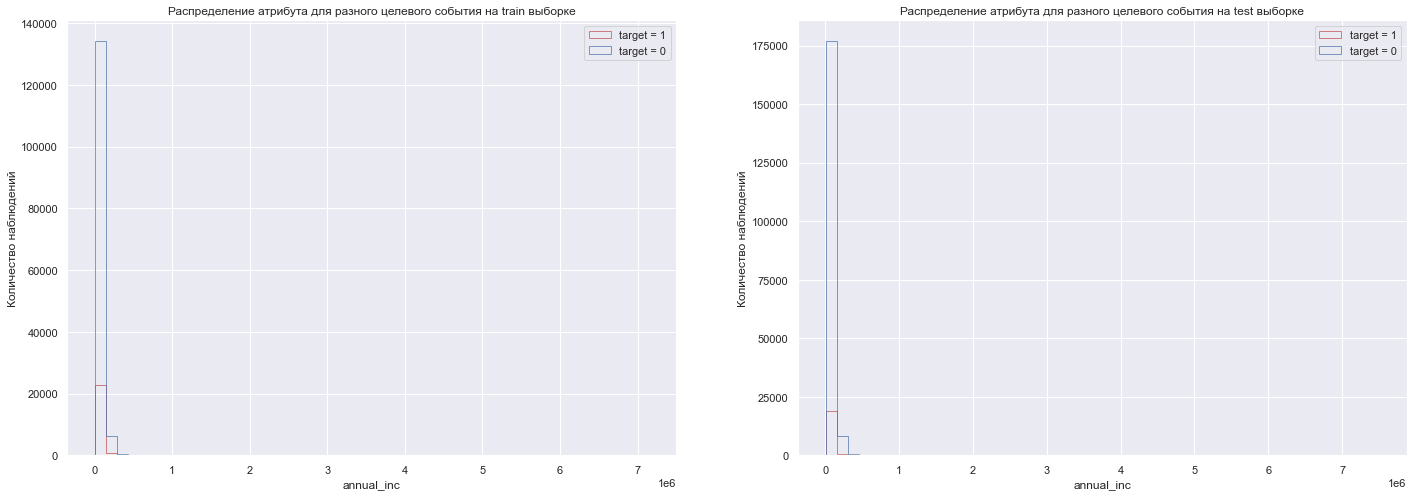


Отображение распределений для атрибута: total_acc


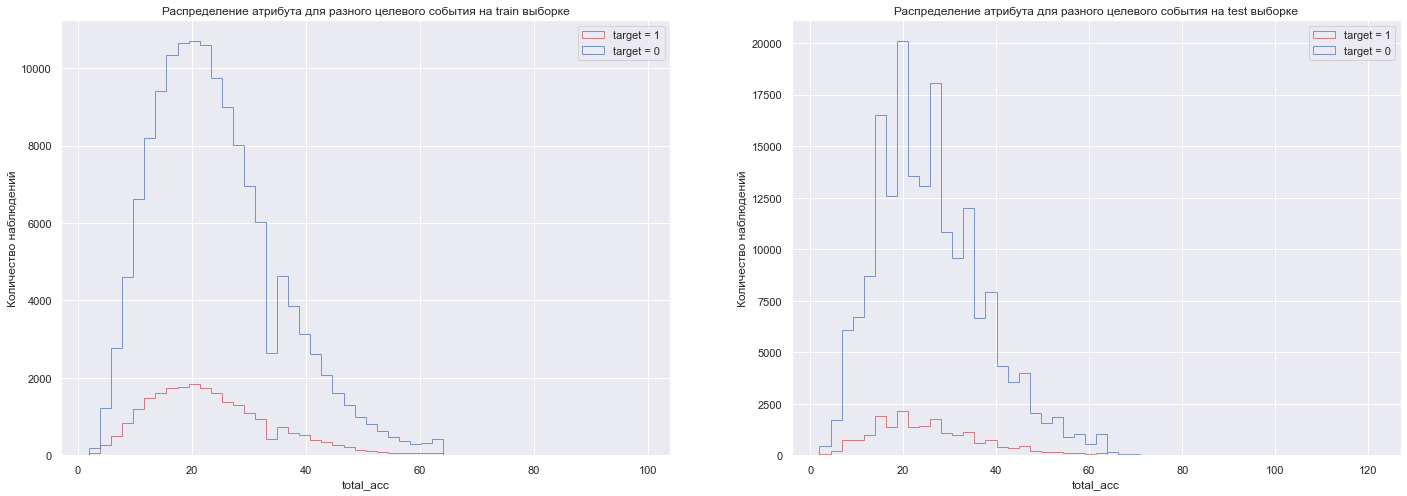


Отображение распределений для атрибута: dti


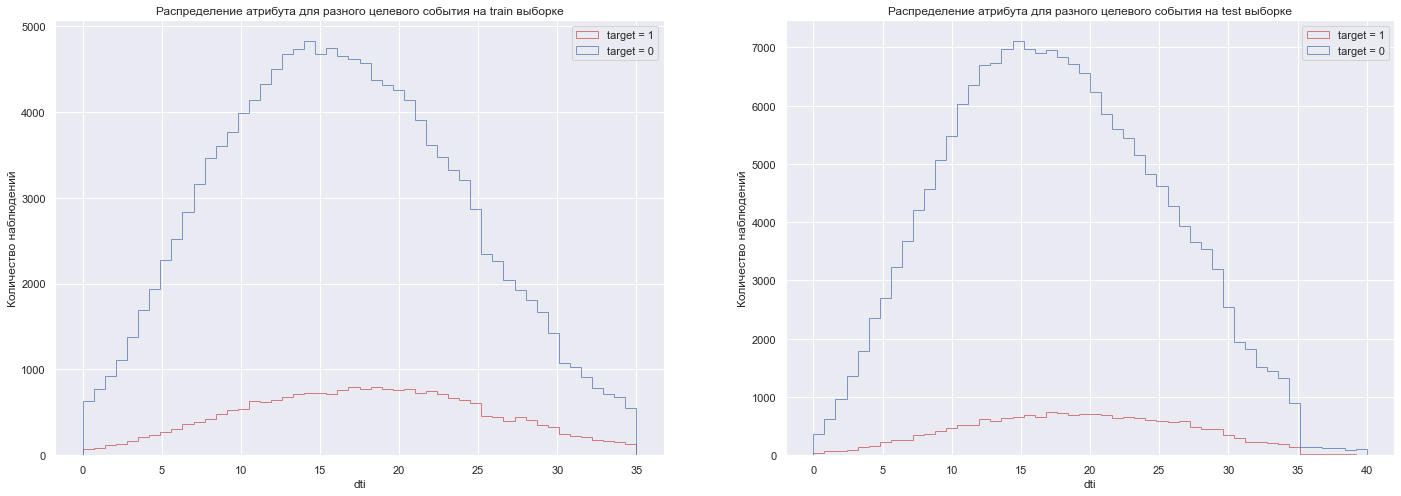


Отображение распределений для атрибута: revol_util


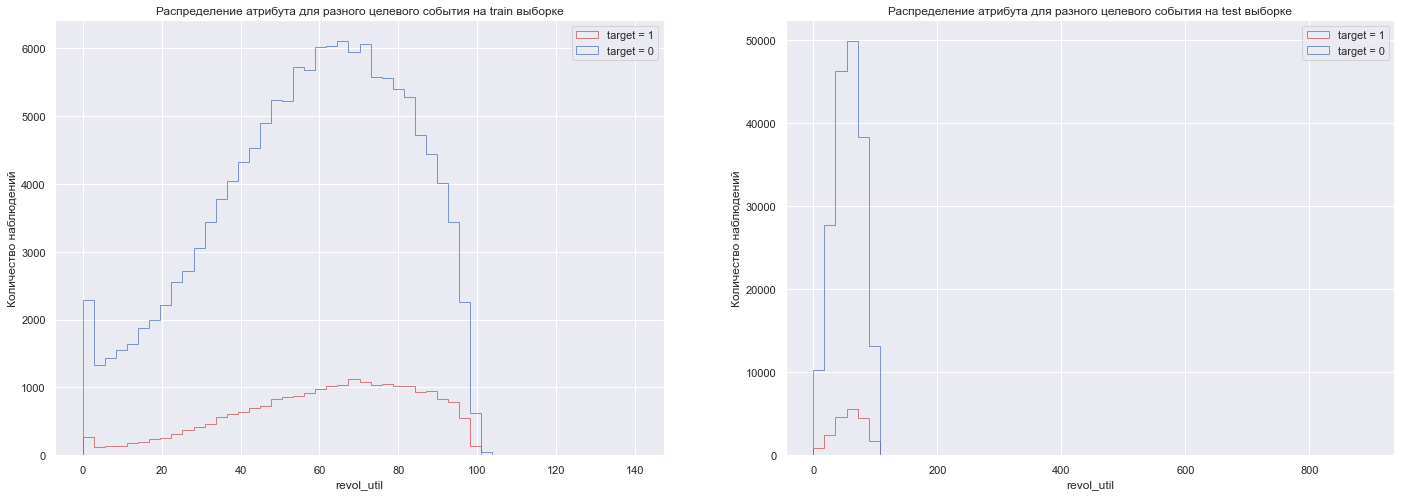


Отображение распределений для атрибута: int_rate


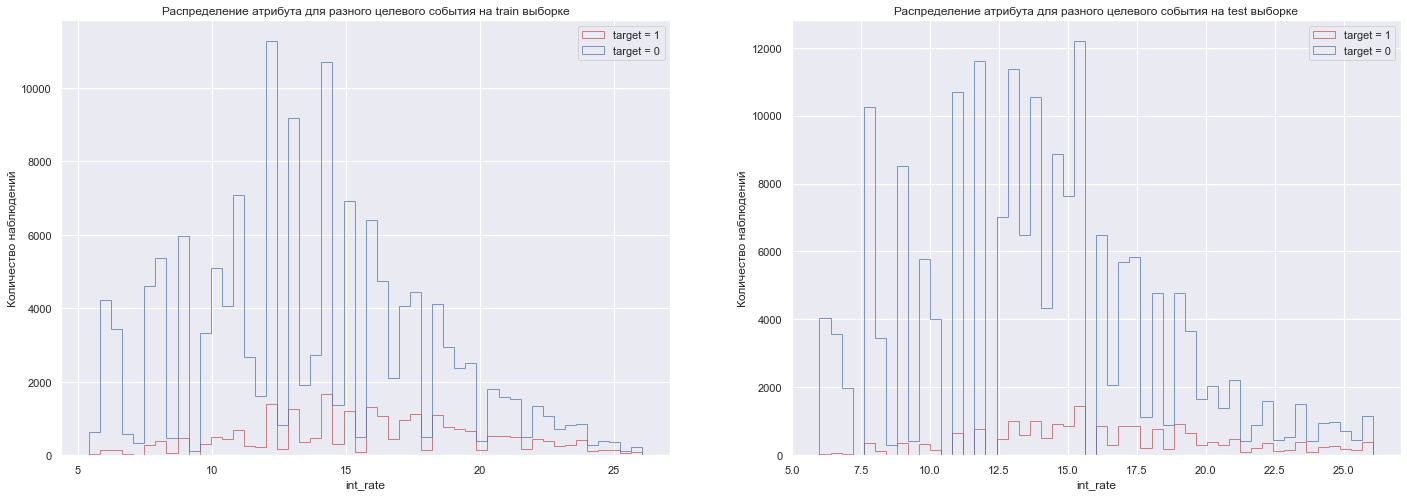


Отображение распределений для атрибута: acc_now_delinq


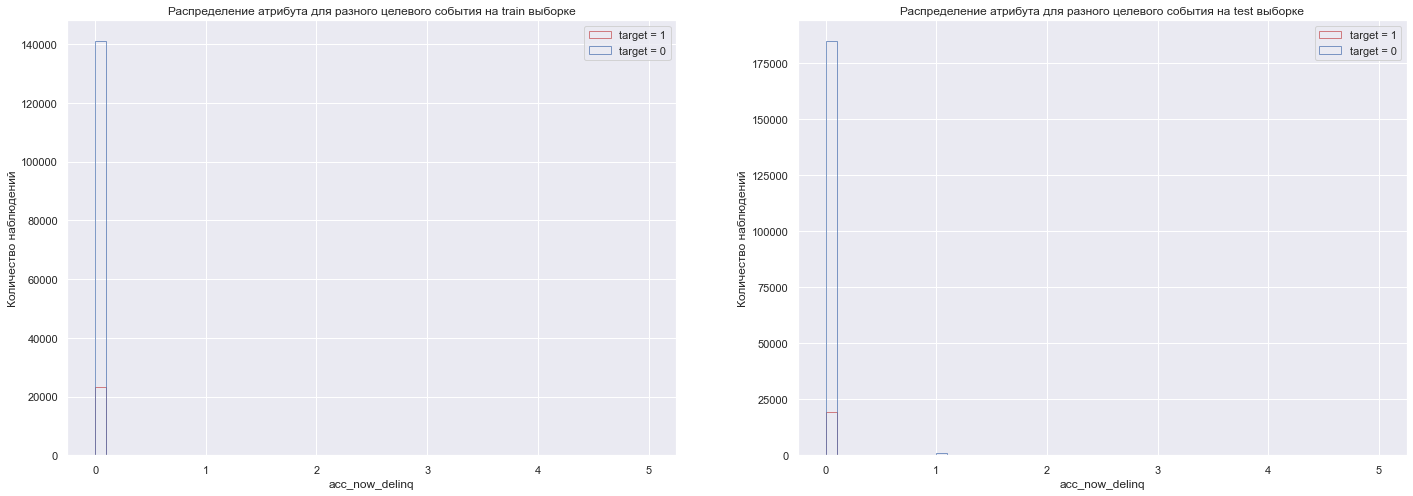


Отображение распределений для атрибута: mths_since_last_major_derog


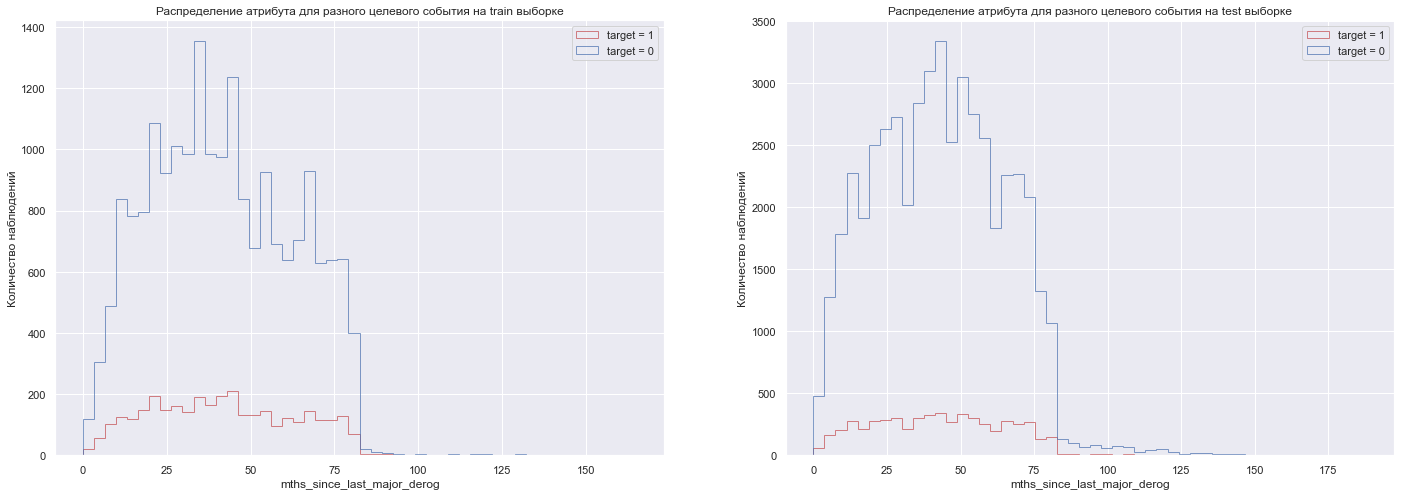


Отображение распределений для атрибута: open_acc


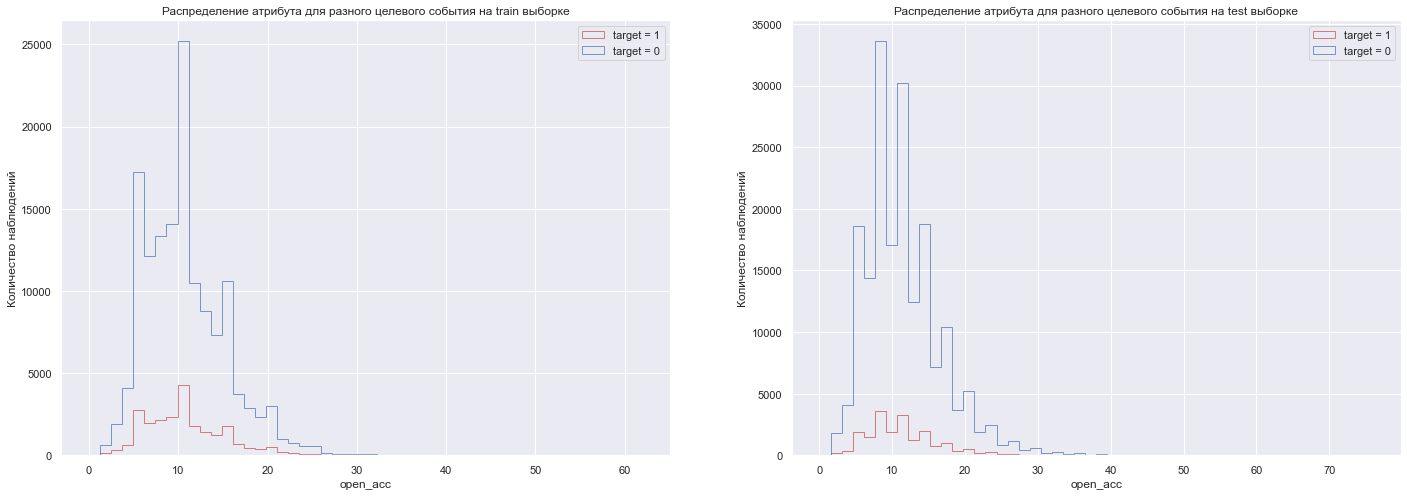


Отображение распределений для атрибута: mths_since_last_delinq


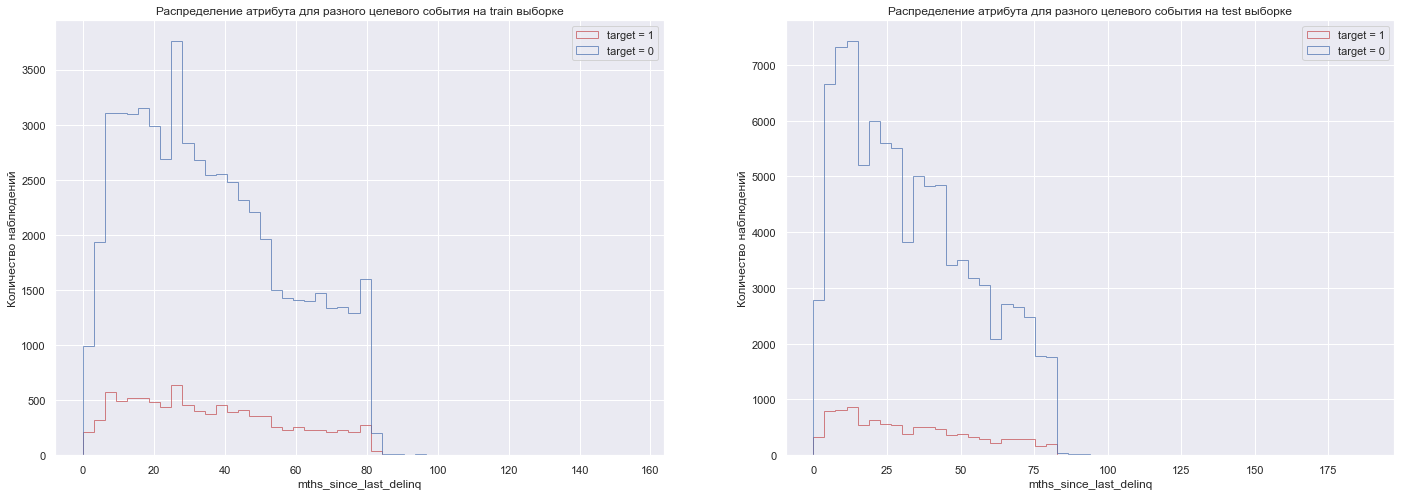


Отображение распределений для атрибута: inq_last_6mths


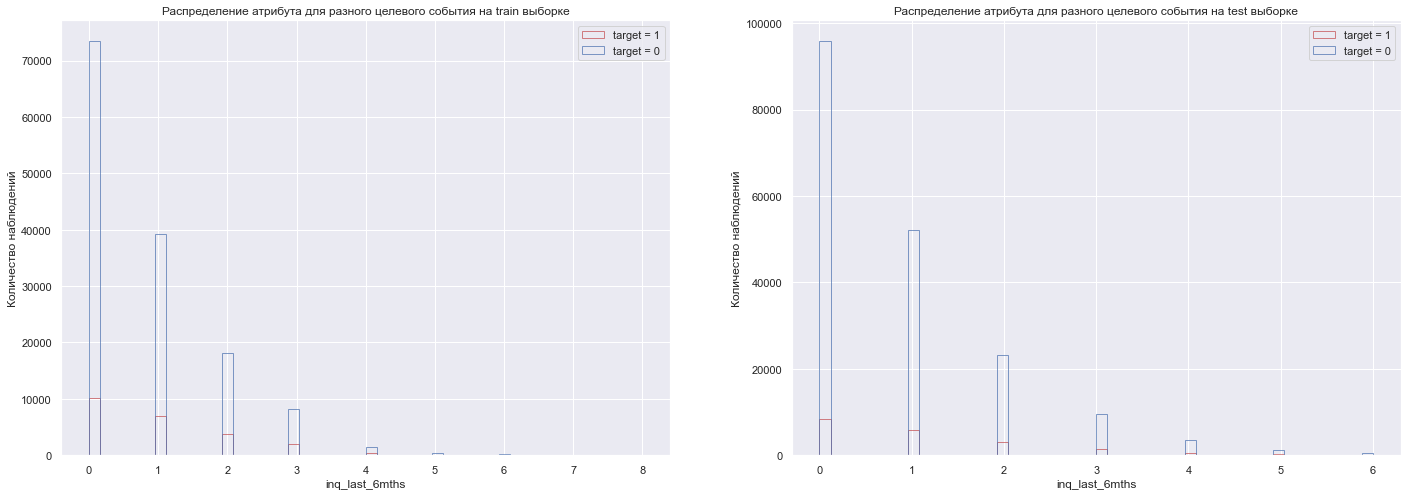


Отображение распределений для атрибута: term


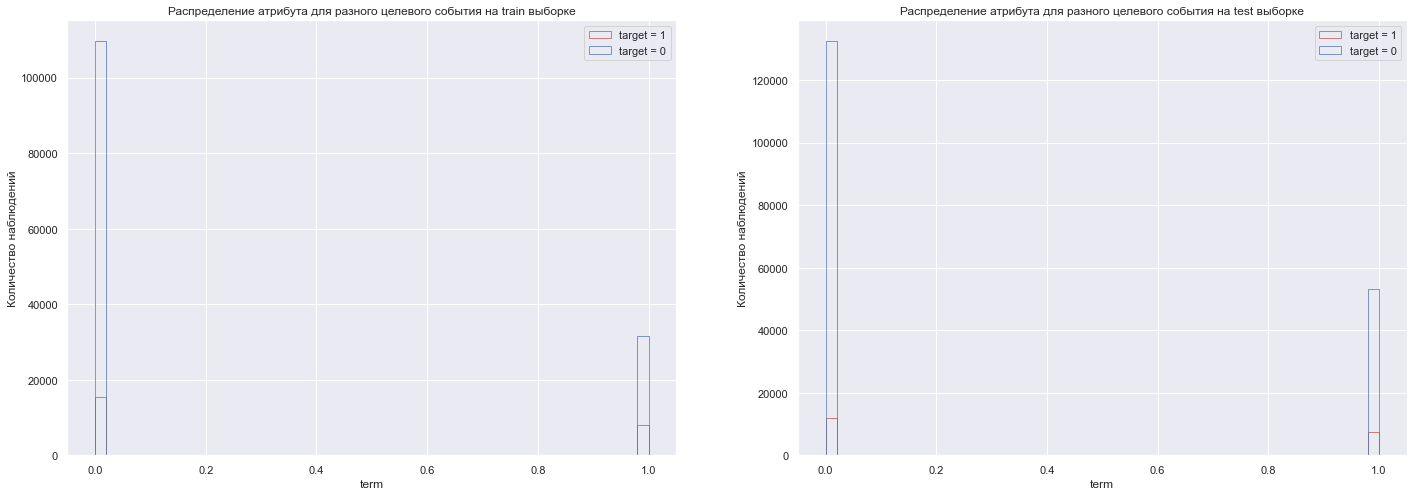


Отображение распределений для атрибута: purpose


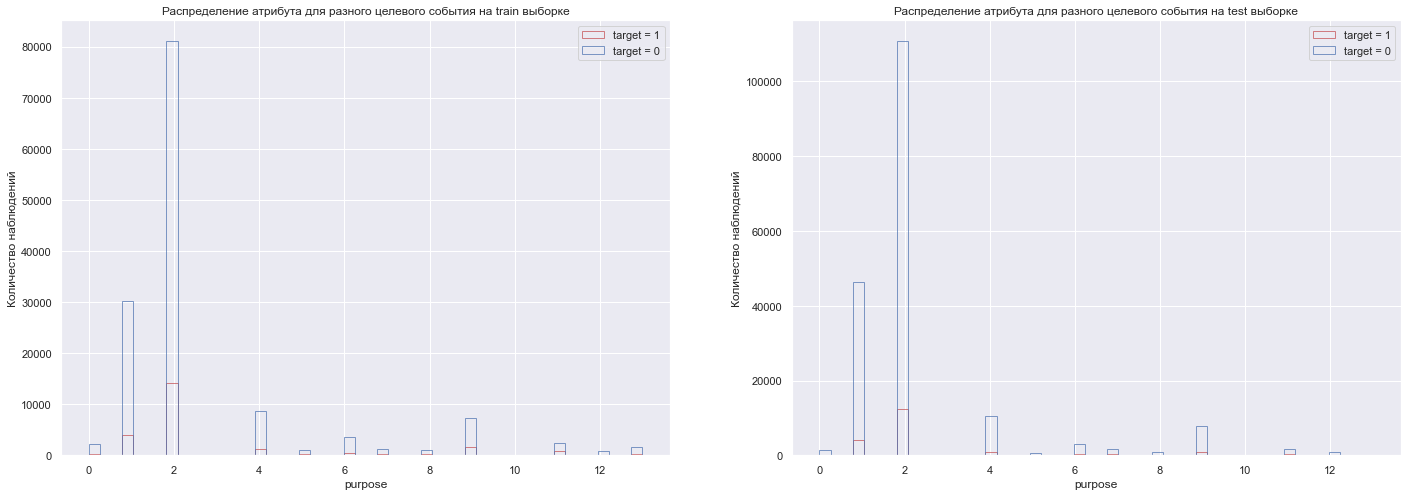


Отображение распределений для атрибута: verification_status


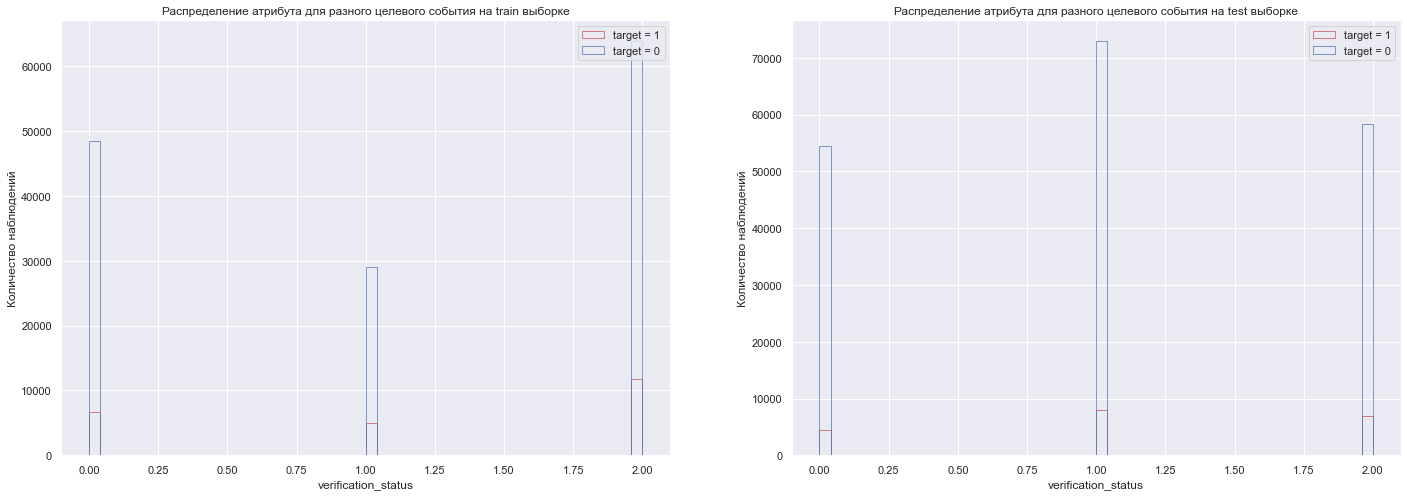


Отображение распределений для атрибута: home_ownership


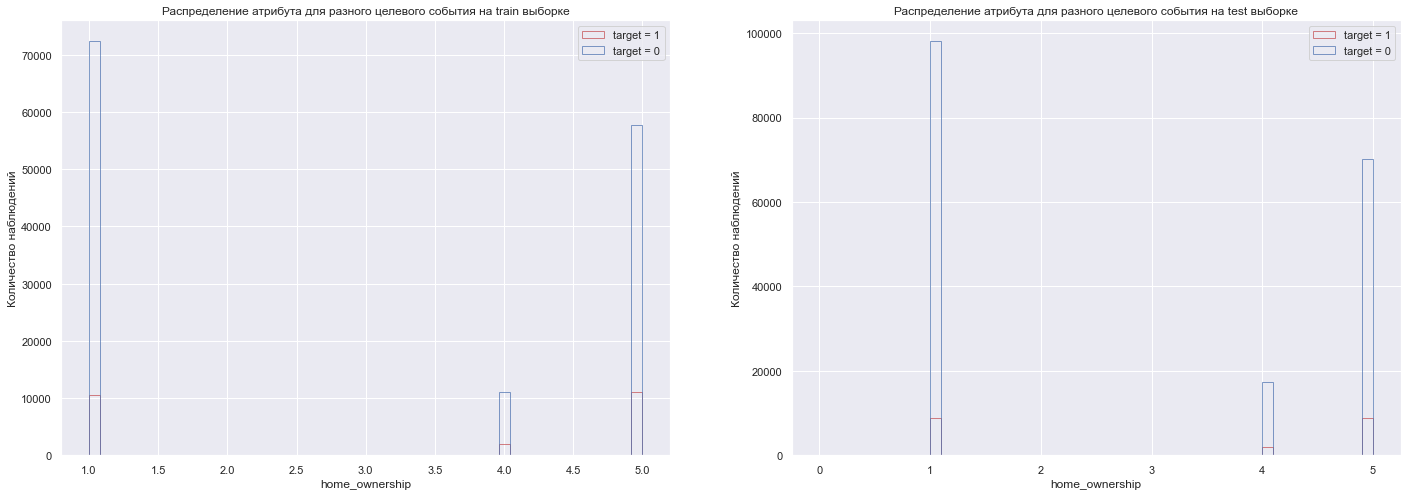


Отображение распределений для атрибута: addr_state


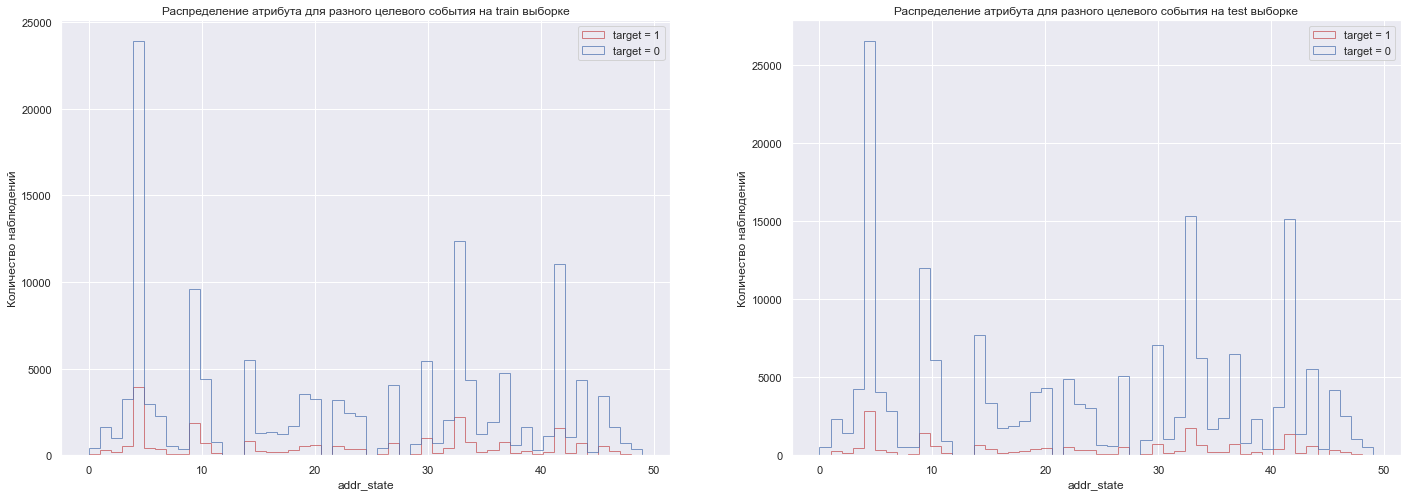


Отображение распределений для атрибута: sub_grade


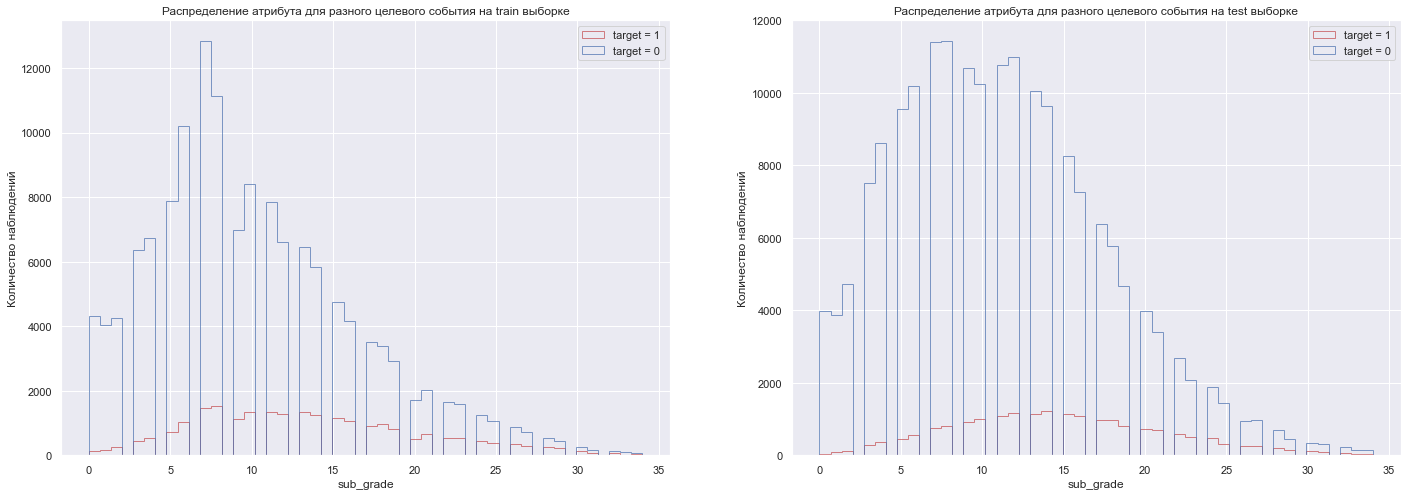


Отображение распределений для атрибута: emp_length


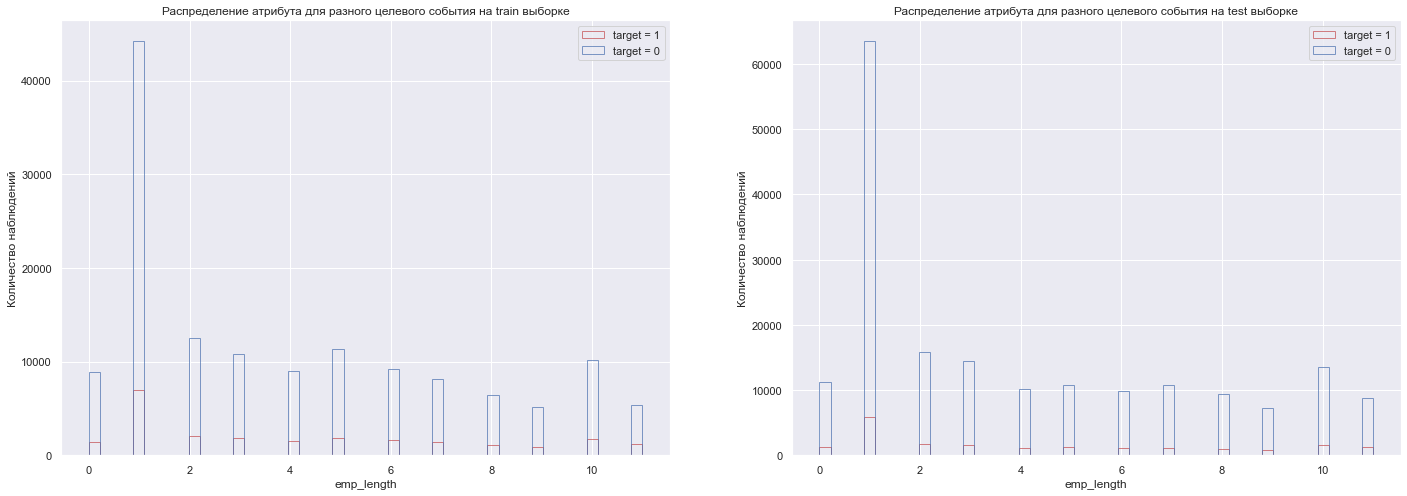


Отображение распределений для атрибута: initial_list_status


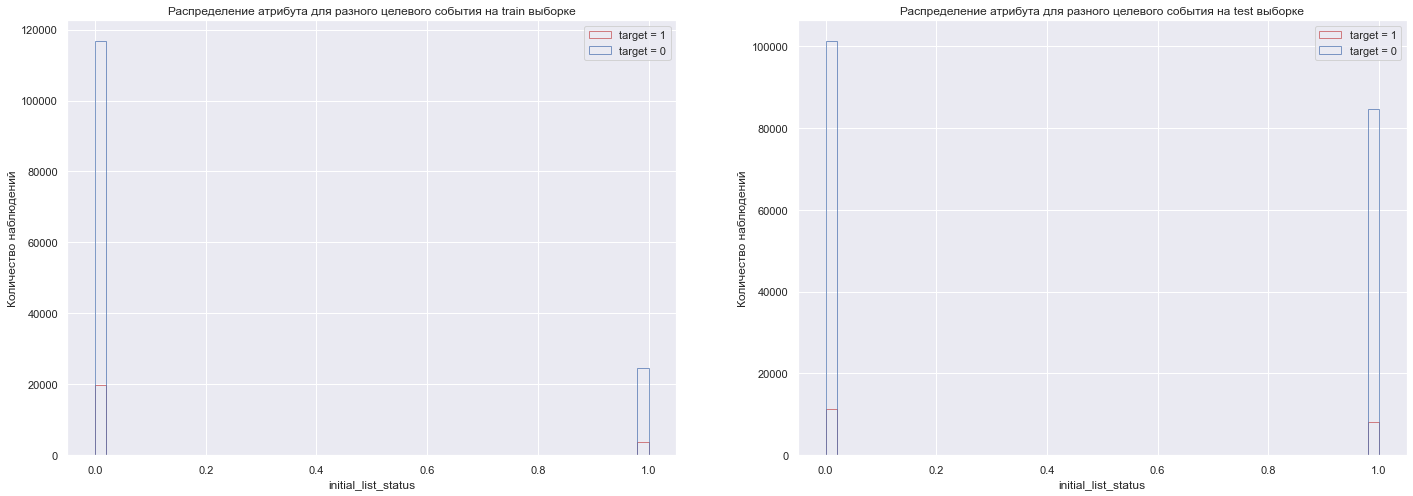

In [80]:
def draw_feature_distribution(data_, interval, category):
    for col in interval + category:
        print(f'Отображение распределений для атрибута: {col}')

        temp_train = data_[data_['test_flg']==0][['target', col]]
        temp_test = data_[data_['test_flg']==1][['target', col]]

        bins = 50

        # Визуализация
        fig = plt.figure(figsize=(24,8))
        ax_1 = fig.add_subplot(1, 2, 1)
        ax_2 = fig.add_subplot(1, 2, 2)

        ax_1.set_title('Распределение атрибута для разного целевого события на train выборке')
        ax_1.hist([temp_train[temp_train['target']==0][col], 
                temp_train[temp_train['target']==1][col]], 
                color=['b','r'],  alpha=0.7, bins=bins, histtype='step', label=['target = 0', 'target = 1'])
        ax_1.set_xlabel(col)
        ax_1.set_ylabel('Количество наблюдений')
        ax_1.legend()

        ax_2.set_title('Распределение атрибута для разного целевого события на test выборке')
        ax_2.hist([temp_test[temp_test['target']==0][col], 
                temp_test[temp_test['target']==1][col]], 
                color=['b','r'],  alpha=0.7, bins=bins, histtype='step', label=['target = 0', 'target = 1'])
        ax_2.set_xlabel(col)
        ax_2.set_ylabel('Количество наблюдений')
        ax_2.legend()

        plt.show()
        print()


draw_feature_distribution(data_ = data_transformed,
                          interval = interrval_features, 
                          category = category_features)

## Поиск аномалий с pyOD, или как рождаются стоп-факторы

Применять поиск аномалий с помощью pyOD будем только на тренировочной выборке, для этого необходимо заполнить пропуски

In [81]:
# Заполнение NaN средним для применения pyOD
# Используем только train выборку
train = data_transformed[data_transformed['test_flg']==0][features].copy()
test = data_transformed[data_transformed['test_flg']==1][features].copy()
for col in train.columns:
    fill_value = train[col].mean()
    train[[col]] = train[[col]].fillna(fill_value)
    test[[col]] = test[[col]].fillna(fill_value)

## Task 3. Поиск аномалий с помощью pyOD

> Реализуйте функцию, которая для каждого наблюдения определит, является ли данное наблюдение выбросом.

> При реализации функции учтите следующее:
* Для поиска аномалий воспользуйтесь библиотекой pyOD, а именно используйте метод pyod.models.pca с долей выбросов равной 0.01 и random_state=42

> Описание функции:
* На вход принимает:
1. Train выборку с атрибутами
1. Test выборку с атрибутами
* Возвращает список лейблов для каждого наблюдения: 1- если наблюдение является выбросом и 0 - если наблюдение не является выбросом

In [82]:
def find_outliers(data_tr, data_ts):
    clf_tr = pyod_PCA(contamination=0.01, random_state=42)
    train_labels = clf_tr.fit(data_tr).labels_
    test_labels = clf_tr.predict(data_ts)

    return train_labels, test_labels

In [83]:
# Проверяем реализацию функции 

assert_outliers_labels_train, assert_outliers_labels_test = find_outliers(data_tr = assert_data_transformed[assert_data_transformed['test_flg']==0][assert_interrval_features + assert_category_features],
                                                                          data_ts = assert_data_transformed[assert_data_transformed['test_flg']==1][assert_interrval_features + assert_category_features],
                                                                          )

assert assert_outliers_labels_train.shape == (313,)
assert assert_outliers_labels_test.shape == (287,)
assert sum(assert_outliers_labels_train) + sum(assert_outliers_labels_test) == 6
assert sum(assert_outliers_labels_train[1000:2500]) == 0
assert sum(assert_outliers_labels_test[2000:4000]) == 0

In [84]:
# Применяем функцию к целевой таблице
outliers_labels_train, outliers_labels_test = find_outliers(data_tr = train,
                                                            data_ts = test,
                                                            )

Воспользуемся методом понижения размерности, чтобы отобразить на плоскости выбросы

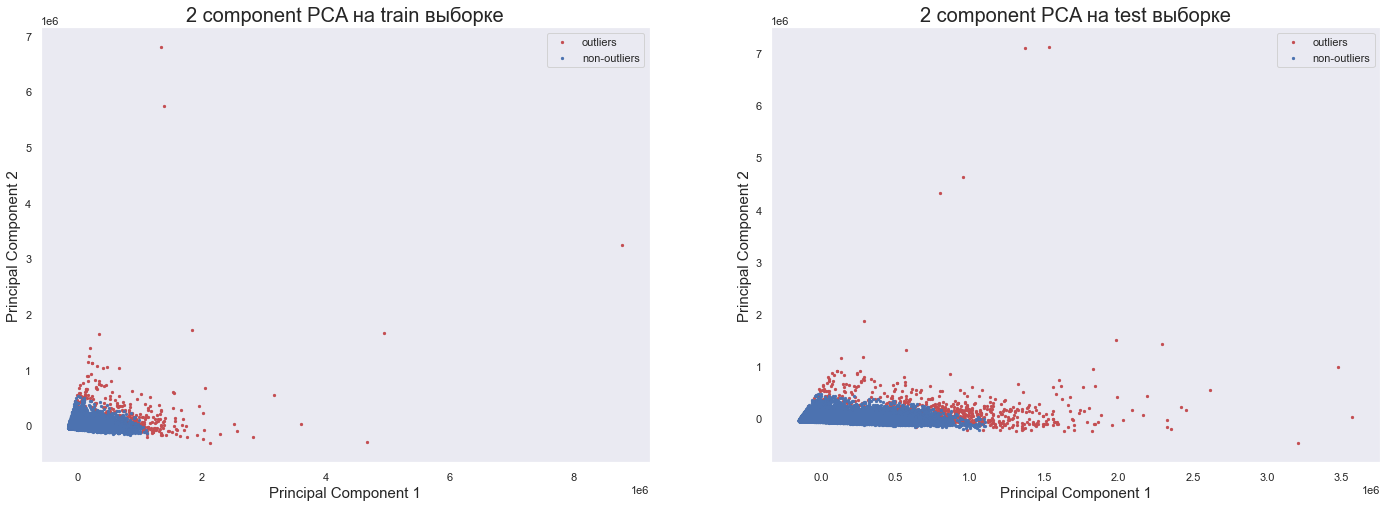

In [85]:
# Применения PCA для визуализации
pca = sklearn.decomposition.PCA(n_components=2)
principalComponents_train = pca.fit_transform(train)
principalComponents_test = pca.transform(test)
principalDf_train = pd.DataFrame(data = principalComponents_train, 
                                 columns = ['principal component 1', 'principal component 2']
                                 )
principalDf_test = pd.DataFrame(data = principalComponents_test, 
                                columns = ['principal component 1', 'principal component 2']
                                )

# Визуализация
fig = plt.figure(figsize = (24,8))
ax_1 = fig.add_subplot(1,2,1) 
ax_2 = fig.add_subplot(1,2,2) 

ax_1.set_xlabel('Principal Component 1', fontsize = 15)
ax_1.set_ylabel('Principal Component 2', fontsize = 15)
ax_1.set_title('2 component PCA на train выборке', fontsize = 20)
ax_1.scatter(principalDf_train.loc[(outliers_labels_train == 1), 'principal component 1'],
             principalDf_train.loc[(outliers_labels_train == 1), 'principal component 2'],
             c = 'r',
             s = 5)
ax_1.scatter(principalDf_train.loc[(outliers_labels_train == 0), 'principal component 1'],
             principalDf_train.loc[(outliers_labels_train == 0), 'principal component 2'],
             c = 'b',
             s = 5)
ax_1.legend(['outliers', 'non-outliers'])
ax_1.grid()

ax_2.set_xlabel('Principal Component 1', fontsize = 15)
ax_2.set_ylabel('Principal Component 2', fontsize = 15)
ax_2.set_title('2 component PCA на test выборке', fontsize = 20)
ax_2.scatter(principalDf_test.loc[(outliers_labels_test == 1), 'principal component 1'],
             principalDf_test.loc[(outliers_labels_test == 1), 'principal component 2'],
             c = 'r',
             s = 5)
ax_2.scatter(principalDf_test.loc[(outliers_labels_test == 0), 'principal component 1'],
             principalDf_test.loc[(outliers_labels_test == 0), 'principal component 2'],
             c = 'b',
             s = 5)
ax_2.legend(['outliers', 'non-outliers'])
ax_2.grid()

In [86]:
data['acc_now_delinq'].value_counts()

0.0    464524
1.0      1623
2.0        92
3.0        11
4.0         4
5.0         2
Name: acc_now_delinq, dtype: int64

In [87]:
# Сравним среднее значение атрибутов в сегменте выбросов и основном сегменте
# Выводим топ-20 атрибутов с самым большим различием в средних

temp = {'col' : [],
        'avg_value_0' : [],
        'avg_value_1' : []
           }
for col in train.columns:
    temp['col'].append(col)
    temp['avg_value_0'].append(train[outliers_labels_train==0][col].mean())
    temp['avg_value_1'].append(train[outliers_labels_train==1][col].mean())
    
mean_factors = pd.DataFrame.from_dict(temp)

mean_factors = mean_factors.append({'col' : 'target',
                                    'avg_value_0' : data_transformed[(data_transformed['test_flg']==0)][outliers_labels_train==0]['target'].mean(),
                                    'avg_value_1' : data_transformed[(data_transformed['test_flg']==0)][outliers_labels_train==1]['target'].mean()
                                   }, ignore_index=True)

mean_factors['delta'] = abs(-mean_factors['avg_value_0'] + mean_factors['avg_value_1'])/mean_factors['avg_value_0']

mean_factors.sort_values('delta', ascending=False).head(11)

,col,avg_value_0,avg_value_1,delta
16,acc_now_delinq,0.000000,0.197328,inf
4,total_rec_late_fee,0.590624,19.427365,31.892974
9,delinq_2yrs,0.199103,1.549484,6.782319
1,pub_rec,0.084997,0.448087,4.271811
5,revol_bal,15468.375863,64067.308440,3.141825
2,total_rev_hi_lim,29200.654874,94363.649693,2.231559
10,tot_cur_bal,133493.428131,381235.097282,1.855834
11,annual_inc,70242.000475,191361.580468,1.724318
8,out_prncp,1454.152385,3724.049957,1.560976
6,total_rec_int,3004.056214,6116.377231,1.036040


Проанализируйте полученные результаты. Сформулируйте выводы.

*Ответ:*

Признаки с наибольшими значениями дельты оказывают значительное влияние, значит можно считать их стоп-факторами

Мы рассмотрели один из способов того, как можно искать некоторые аномалии или экстремальные значения в данных.


Примените другие, знакомые вам способы поиска нетипичных клиентов. На основе полученных данных сформулируйте список ограничений (стоп-факторов), который необходимо наложить на список клиентов для моделирования.

In [88]:
# YOUR CODE HERE

def stop_factors_remove_from_dataset(df):
    df = df.drop(df[df['acc_now_delinq']>0].index) #не даем тем, у кого есть задолжности по другим кредитам
    df = df.drop(df[df['total_rec_late_fee']>2].index) #просроченные плажежи
    df = df.drop(df[df['pub_rec']>0].index) #Количество унизительных публичных записей

    
    return df

*Список стоп-факторов:*

# Сохранение обработанного датасета

Исключите плохие атрибуты и обработайте датасет с учетом стоп-факторов.

In [89]:
index = list(train[(outliers_labels_train == 0)].index) + list(test[(outliers_labels_test == 0)].index) # YOUR CODE HERE
data_transformed_filtered = data_transformed.loc[index, [col for col in data_transformed.columns if col not in bad_features]]

data_transformed_filtered = stop_factors_remove_from_dataset(data_transformed_filtered.copy())

print(data_transformed_filtered.shape)
data_transformed_filtered.head()

(311521, 32)


,loan_amnt,term,int_rate,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,...,total_rec_prncp,total_rec_int,total_rec_late_fee,last_pymnt_amnt,mths_since_last_major_derog,acc_now_delinq,tot_cur_bal,total_rev_hi_lim,target,test_flg
0,5000,0,10.65,6,1,5,24000.0,2,2011-12-01,1,...,5000.00,861.07,0.0,171.62,NaN,0.0,NaN,NaN,0,0
1,2500,1,15.27,13,10,5,30000.0,1,2011-12-01,0,...,456.46,435.17,0.0,119.66,NaN,0.0,NaN,NaN,1,0
2,2400,0,15.96,14,1,5,12252.0,0,2011-12-01,11,...,2400.00,603.65,0.0,649.91,NaN,0.0,NaN,NaN,0,0
4,3000,1,12.69,9,0,5,80000.0,1,2011-12-01,9,...,2233.10,1009.07,0.0,67.79,NaN,0.0,NaN,NaN,0,0
5,5000,0,7.90,3,3,5,36000.0,1,2011-12-01,13,...,5000.00,631.38,0.0,161.03,NaN,0.0,NaN,NaN,0,0


Сохраняем обработанный датасет (с учетом стоп-факторов) и список категориальных атрибутов для будущего использования

In [90]:
data_transformed_filtered.to_csv('./dataset_2_out.csv', index=False)

In [91]:
with open('./category_features.pickle', 'wb') as f:
    pickle.dump(category_features, f)

# Заполните, пожалуйста, обратную связь по ДЗ
https://forms.gle/AY2Qadf1FBXArCuv7